# Проверка гипотезы о влиянии технических индикаторов на цену актива на примере BTCUSDT

*Гипотеза: Технические индикаторы, такие как скользящие средние (SMA, EMA), индекс относительной силы (RSI), MACD и объёмные индикаторы (OBV), а также их сочетания, обладают предиктивной способностью относительно будущей цены выбранного нейросетевого актива. Изменения в значениях этих индикаторов на текущем и предыдущих временных интервалах могут использоваться для прогнозирования краткосрочных движений цены актива.*

Пул доступных индикаторов: SMA, EMA, WMA, HMA, MACD, Parabolic SAR, Ichimoku, Bollinger Bands, Keltner Channels, Donchian Channels, ATR, RSI, Stochastic RSI, ADX, Williams %R, CCI, ROC, Momentum, OBV, CMF, MFI, VWAP, Volume Profile

## Подготовка данных

Импорты

In [1]:
from EDA.utils.indicator_сalculator import IndicatorCalculator
from EDA.utils.bitcoin_parser import BitCoinParser
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


Подготовим данные для тестирования. Возьмём данные за 2 дня с поминутным интервалом, так как это больше всего подходит к нашему техничекому заданию

In [2]:
start_time = int(datetime(2026, 1, 1).timestamp()) * 1000
end_time = int(datetime(2026, 1, 3).timestamp()) * 1000

df, path = BitCoinParser.get_and_save_full_history_sync(start_time, end_time, filename="btc_history.csv")
print(f"Данные загружены: {df.shape[0]} строк")

2026-02-28 19:07:54,981 [INFO] Начало загрузки полной истории BTCUSDT с 1767214800000 по 1767387600000
2026-02-28 19:07:56,260 [INFO] HTTP Request: GET https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=1&end=1767387600000&limit=200 "HTTP/1.1 200 OK"
2026-02-28 19:07:57,574 [INFO] HTTP Request: GET https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=1&end=1767375600000&limit=200 "HTTP/1.1 200 OK"
2026-02-28 19:07:58,818 [INFO] HTTP Request: GET https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=1&end=1767363600000&limit=200 "HTTP/1.1 200 OK"
2026-02-28 19:08:00,135 [INFO] HTTP Request: GET https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=1&end=1767351600000&limit=200 "HTTP/1.1 200 OK"
2026-02-28 19:08:01,509 [INFO] HTTP Request: GET https://api.bybit.com/v5/market/kline?category=linear&symbol=BTCUSDT&interval=1&end=1767339600000&limit=200 "HTTP/1.1 200 OK"
2026-02-28 19:08:02,93

Данные загружены: 2881 строк


Посмотрим на данные

In [3]:
print(df.shape)
df.head()

(2881, 5)


open     high      low    close   volume
timestamp                                                 
1767214800000  87621.5  87672.3  87621.5  87666.0   59.786
1767214860000  87666.0  87670.7  87645.8  87645.8   16.237
1767214920000  87645.8  87736.8  87645.8  87696.5  107.031
1767214980000  87696.5  87728.8  87696.4  87696.5   17.430
1767215040000  87696.5  87696.5  87663.7  87669.0   51.011

In [4]:
print(df.info())
print("Сумма Na", df.isna().sum())
print(df.describe())

<class 'pandas.DataFrame'>
RangeIndex: 2881 entries, 1767214800000 to 1767387600000
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    2881 non-null   float64
 1   high    2881 non-null   float64
 2   low     2881 non-null   float64
 3   close   2881 non-null   float64
 4   volume  2881 non-null   float64
dtypes: float64(5)
memory usage: 112.7 KB
None
Сумма Na open      0
high      0
low       0
close     0
volume    0
dtype: int64
               open          high           low         close       volume
count   2881.000000   2881.000000   2881.000000   2881.000000  2881.000000
mean   88523.489170  88542.830233  88505.333044  88524.218743    35.393120
std      799.018979    812.032572    786.504428    799.154695    71.704046
min    87519.600000  87545.900000  87515.000000  87519.600000     0.131000
25%    87844.900000  87852.400000  87835.500000  87845.200000     5.734000
50%    88328.300000  88343.500000  88320.80000

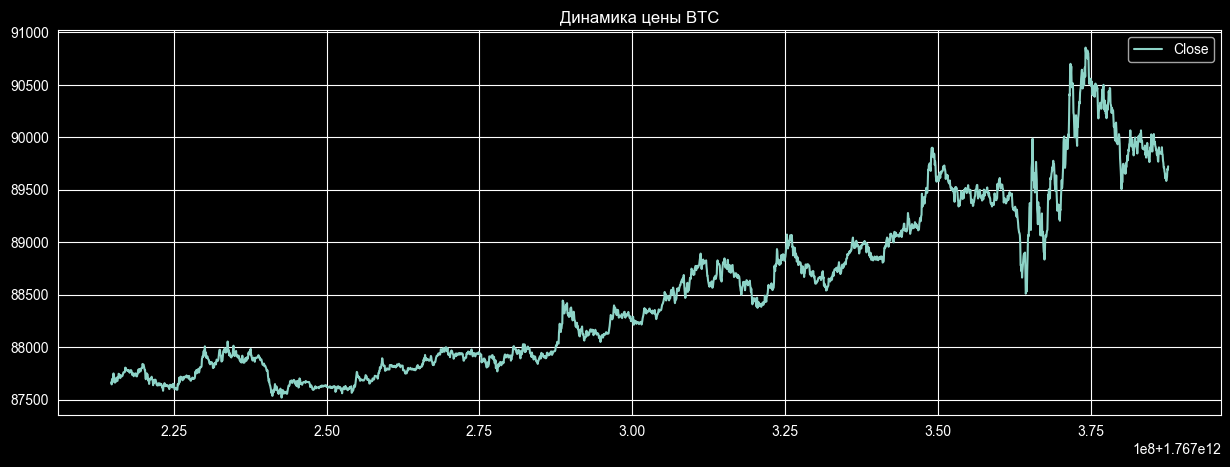

In [5]:
plt.figure(figsize=(15,5))
plt.plot(df['close'], label='Close')
plt.title('Динамика цены BTC')
plt.legend()
plt.show()

## Подготовка индикаторов

Для начала добавим к данным все технические индикаторы из пула

In [3]:
df_ind = IndicatorCalculator.add_all_indicators(df)
df_ind.tail() # почти все индикаторы в начале null

open     high      low    close  volume     sma_20  \
timestamp                                                              
1767387360000  89584.5  89622.0  89580.0  89606.0  37.595  89752.045   
1767387420000  89606.0  89622.8  89575.1  89622.5  18.383  89740.370   
1767387480000  89622.5  89699.0  89622.5  89699.0  47.599  89733.030   
1767387540000  89699.0  89747.9  89681.3  89690.0  87.530  89724.745   
1767387600000  89690.0  89746.7  89676.3  89723.4  25.014  89717.995   

                  sma_50     sma_200        ema_12        ema_26  ...  \
timestamp                                                         ...   
1767387360000  89831.904  89998.6545  89674.802930  89745.393226  ...   
1767387420000  89828.352  89994.3230  89666.756325  89736.290024  ...   
1767387480000  89826.440  89990.8605  89671.716890  89733.527800  ...   
1767387540000  89824.958  89987.1540  89674.529677  89730.303519  ...   
1767387600000  89823.244  89983.8360  89682.048188  89729.792147  ...   

               kijun_sen  senkou_span_a  senkou_span_b  chikou_span  \
timestamp                                                             
1767387360000   89744.45      89904.850       89911.55          NaN   
1767387420000   89744.10      89891.600       89911.55          NaN   
1767387480000   89744.10      89877.425       89911.55          NaN   
1767387540000   89744.10      89875.250       89911.55          NaN   
1767387600000   89744.10      89872.500       89911.55          NaN   

               parabolic_sar          vwap       obv    cmf_20    roc_12  \
timestamp                                                                  
1767387360000        89575.8  89160.111097  4132.597 -0.282153 -0.268012   
1767387420000        89575.1  89160.191754  4150.980 -0.258502 -0.234990   
1767387480000        89575.1  89160.431634  4198.579 -0.168038 -0.087550   
1767387540000        89622.5  89160.900414  4111.049 -0.222547 -0.073199   
1767387600000        89676.3  89161.036456  4136.063 -0.224026  0.015271   

               momentum_10  
timestamp                   
1767387360000       -171.6  
1767387420000       -133.2  
1767387480000        -10.7  
1767387540000        -22.1  
1767387600000         47.8  

[5 rows x 47 columns]

In [7]:
df_ind.shape

(2881, 47)

In [8]:
df_ind.info()

<class 'pandas.DataFrame'>
RangeIndex: 2881 entries, 1767214800000 to 1767387600000
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            2881 non-null   float64
 1   high            2881 non-null   float64
 2   low             2881 non-null   float64
 3   close           2881 non-null   float64
 4   volume          2881 non-null   float64
 5   sma_20          2862 non-null   float64
 6   sma_50          2832 non-null   float64
 7   sma_200         2682 non-null   float64
 8   ema_12          2870 non-null   float64
 9   ema_26          2856 non-null   float64
 10  wma_20          2862 non-null   float64
 11  hma_20          2859 non-null   float64
 12  rsi_14          2867 non-null   float64
 13  stoch_k         2852 non-null   float64
 14  stoch_d         2850 non-null   float64
 15  williams_r      2868 non-null   float64
 16  cci_20          2862 non-null   float64
 17  mfi_14          2868 no

Избавимся от пропусков, обрезав датасет (пропуски есть ТОЛЬКО в начале)

In [4]:
df_ind = df_ind[201:]

In [10]:
df_ind.info()

<class 'pandas.DataFrame'>
RangeIndex: 2680 entries, 1767226860000 to 1767387600000
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   open            2680 non-null   float64
 1   high            2680 non-null   float64
 2   low             2680 non-null   float64
 3   close           2680 non-null   float64
 4   volume          2680 non-null   float64
 5   sma_20          2680 non-null   float64
 6   sma_50          2680 non-null   float64
 7   sma_200         2680 non-null   float64
 8   ema_12          2680 non-null   float64
 9   ema_26          2680 non-null   float64
 10  wma_20          2680 non-null   float64
 11  hma_20          2680 non-null   float64
 12  rsi_14          2680 non-null   float64
 13  stoch_k         2680 non-null   float64
 14  stoch_d         2680 non-null   float64
 15  williams_r      2680 non-null   float64
 16  cci_20          2680 non-null   float64
 17  mfi_14          2680 no

Пропусков больше нет

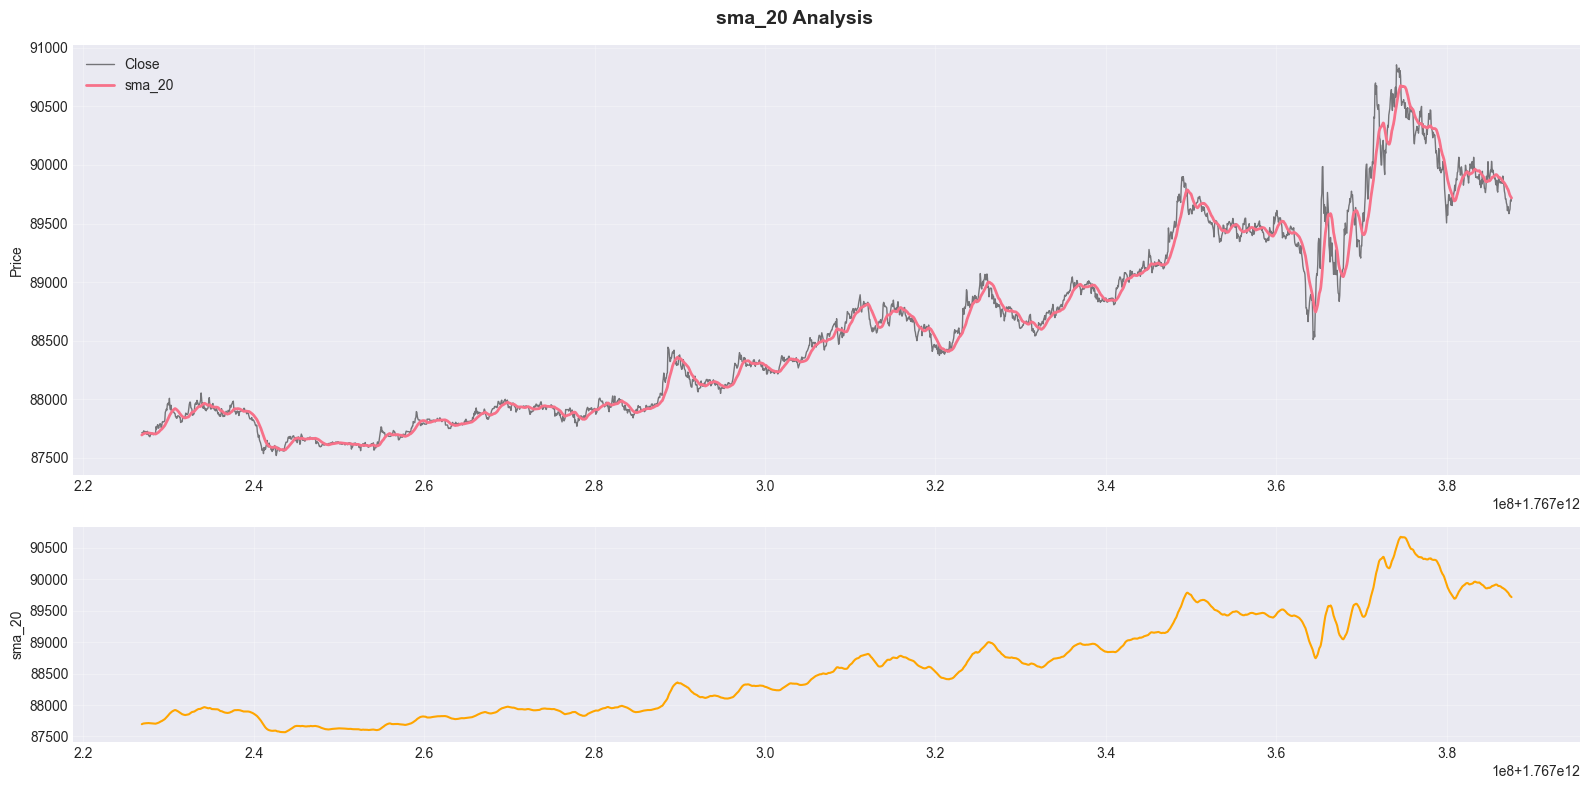

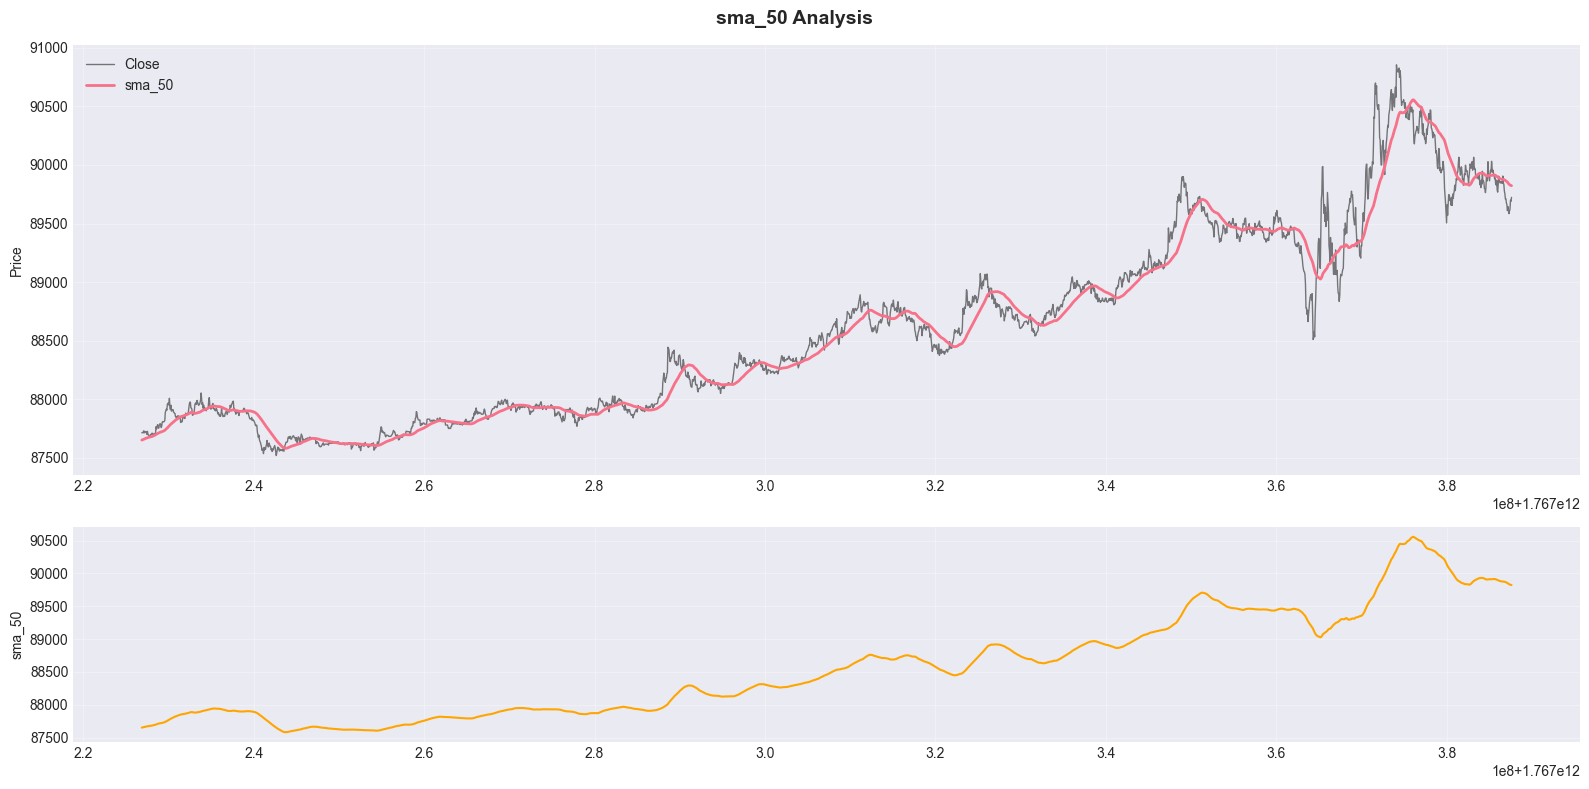

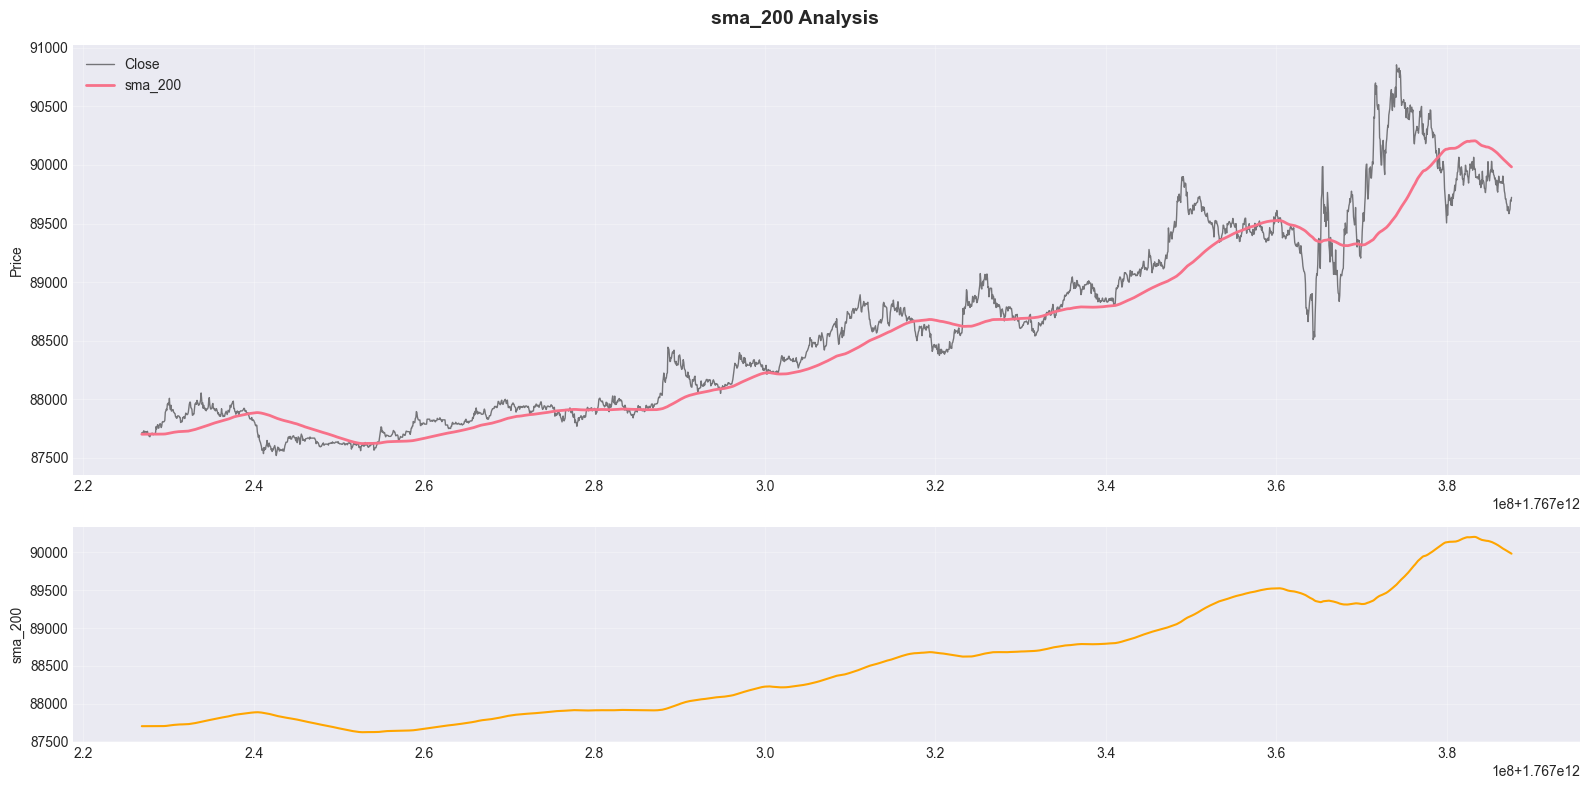

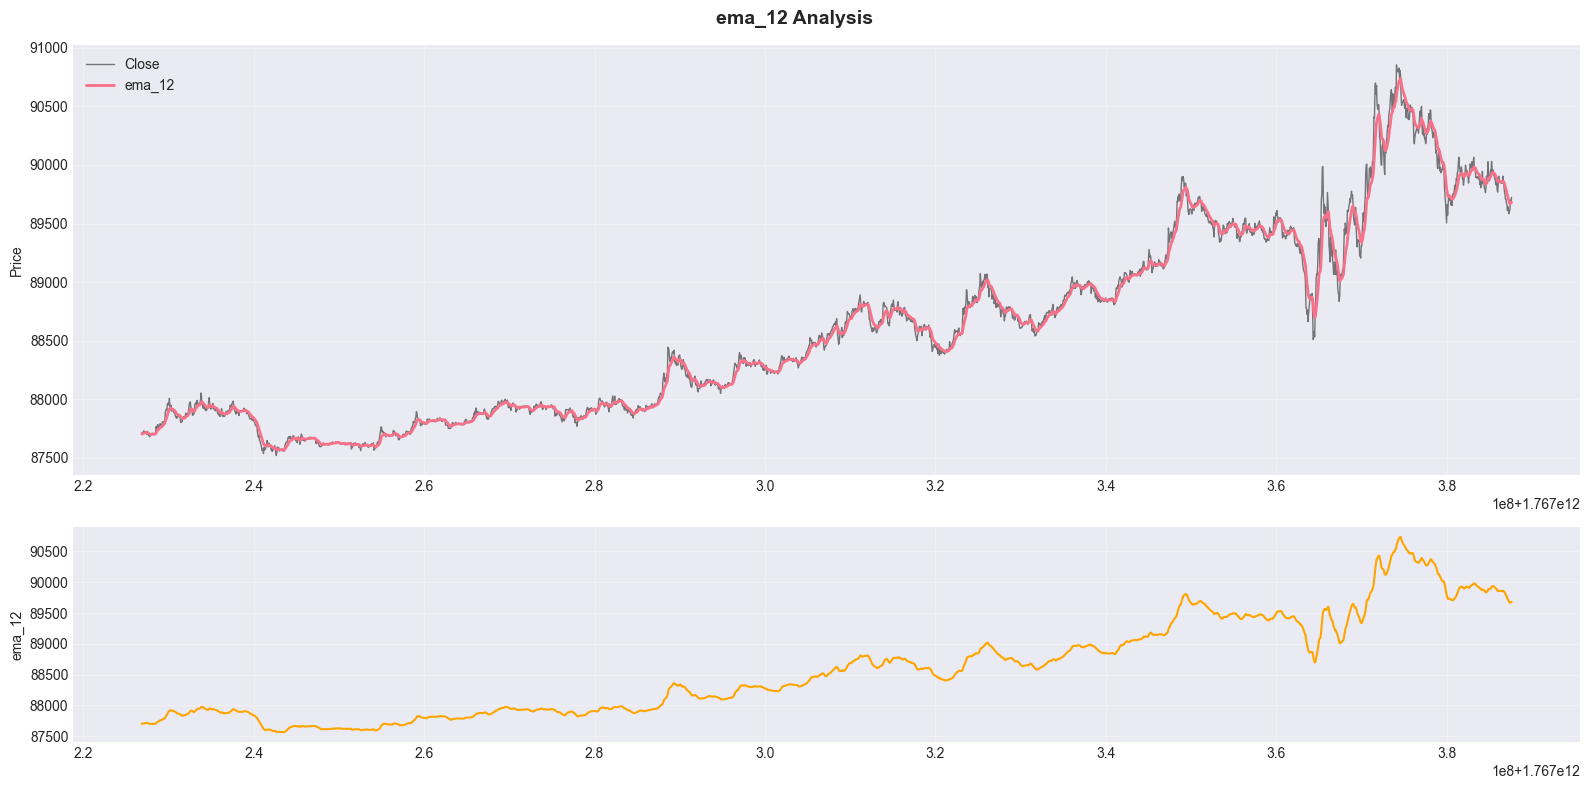

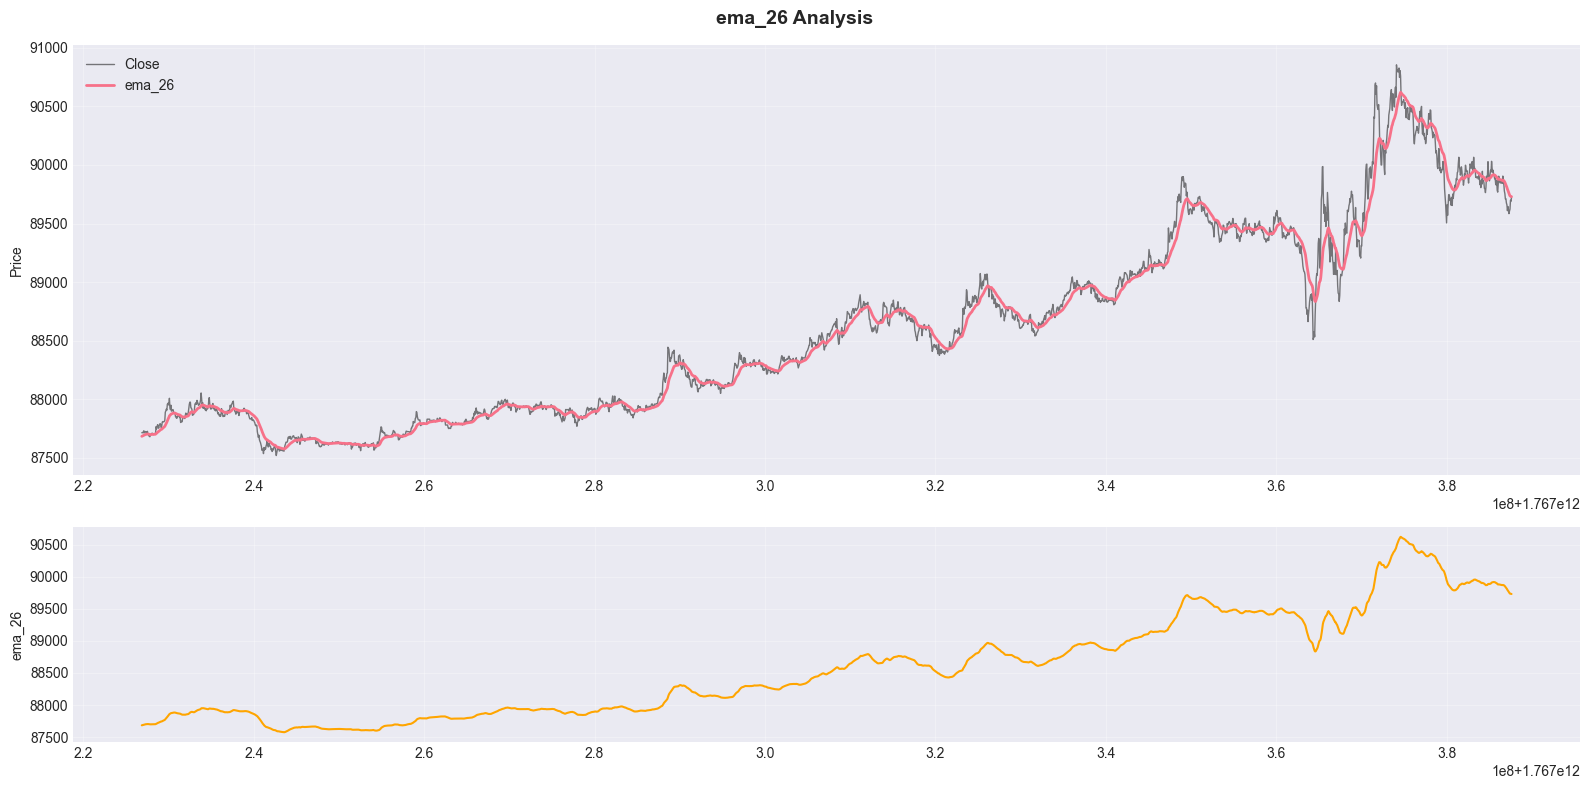

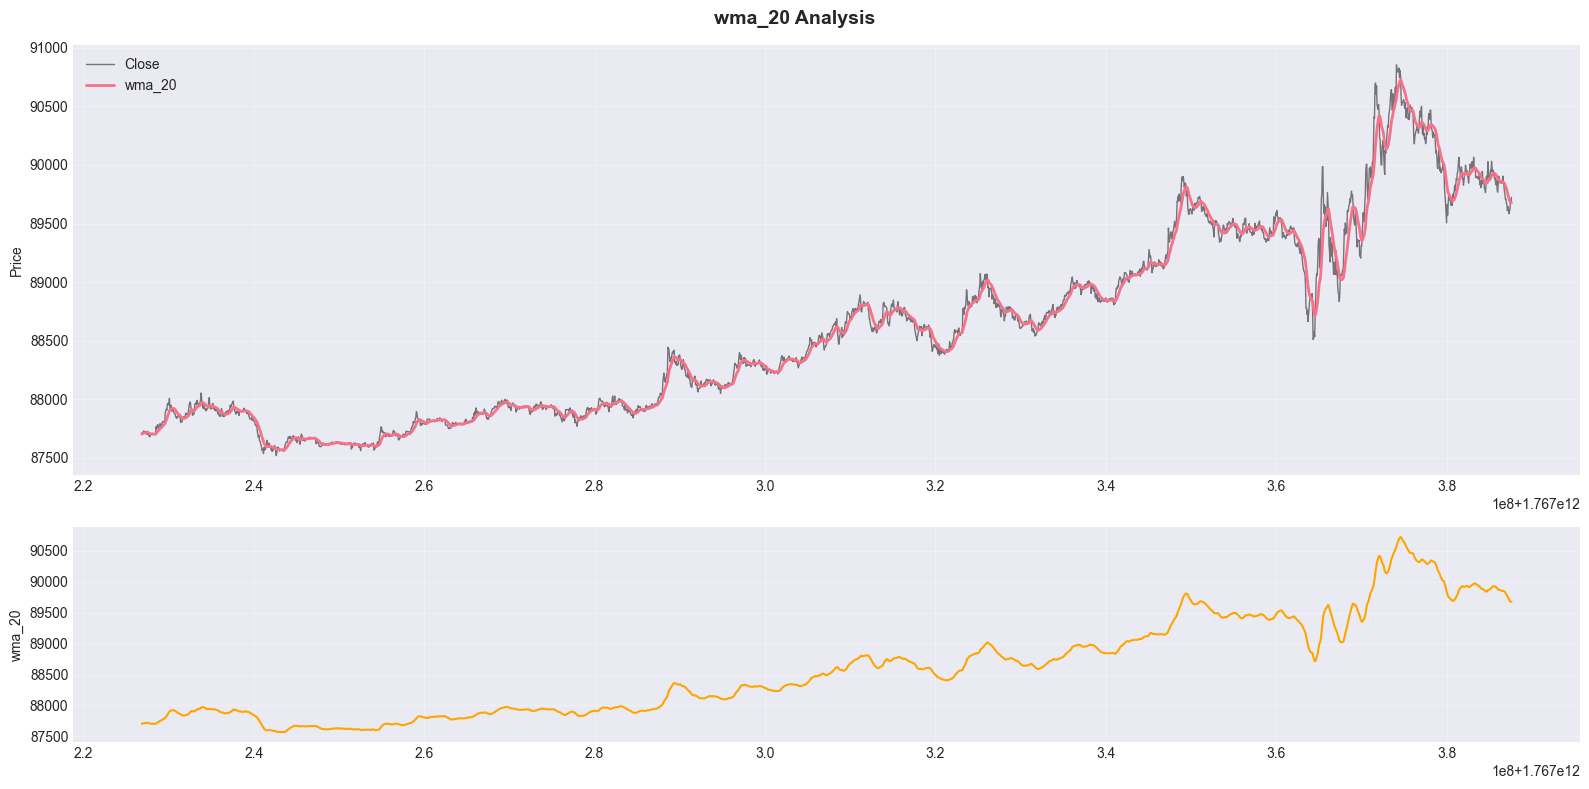

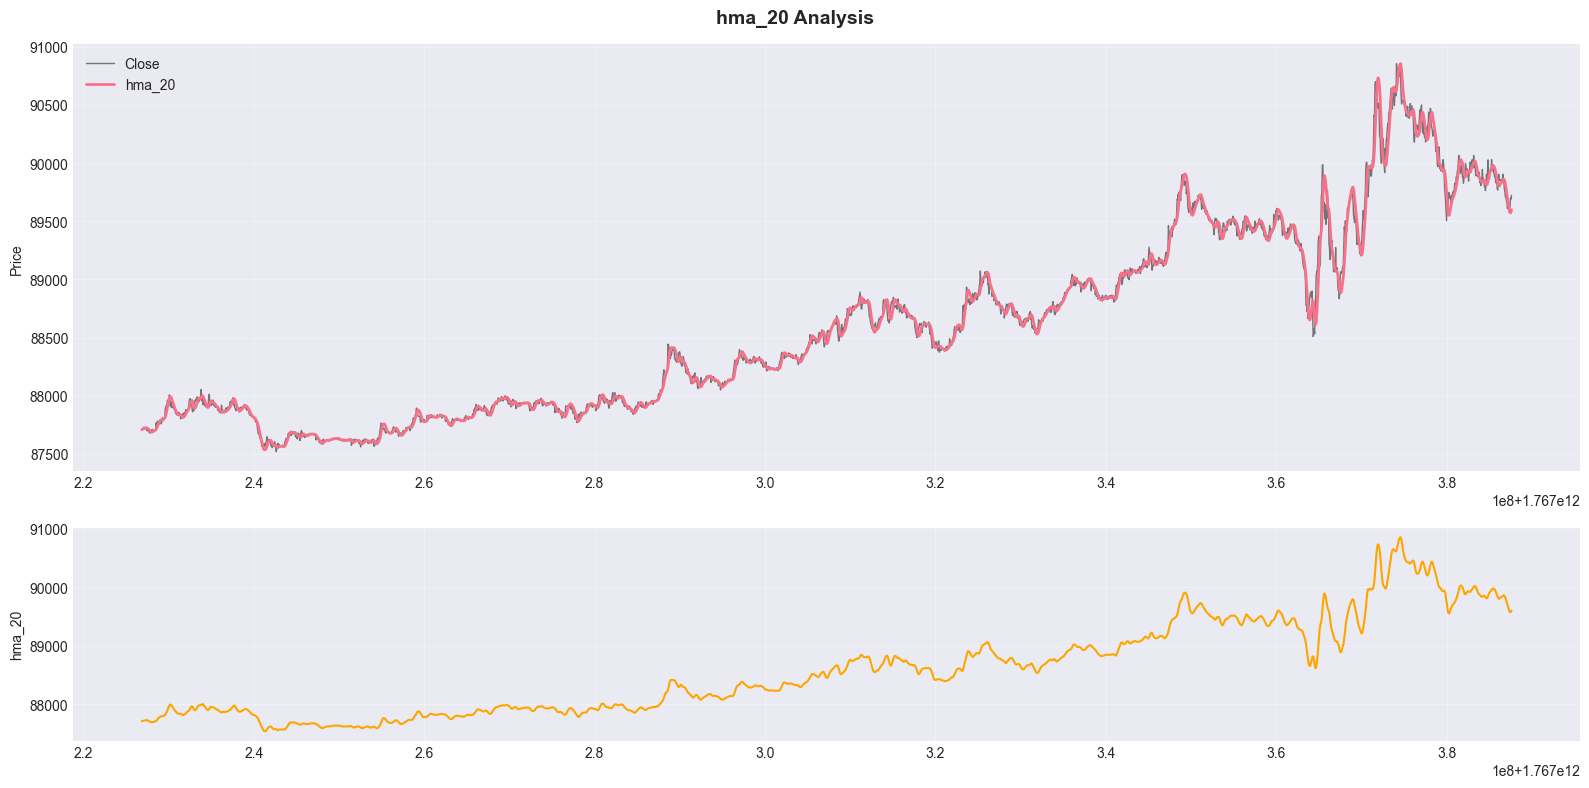

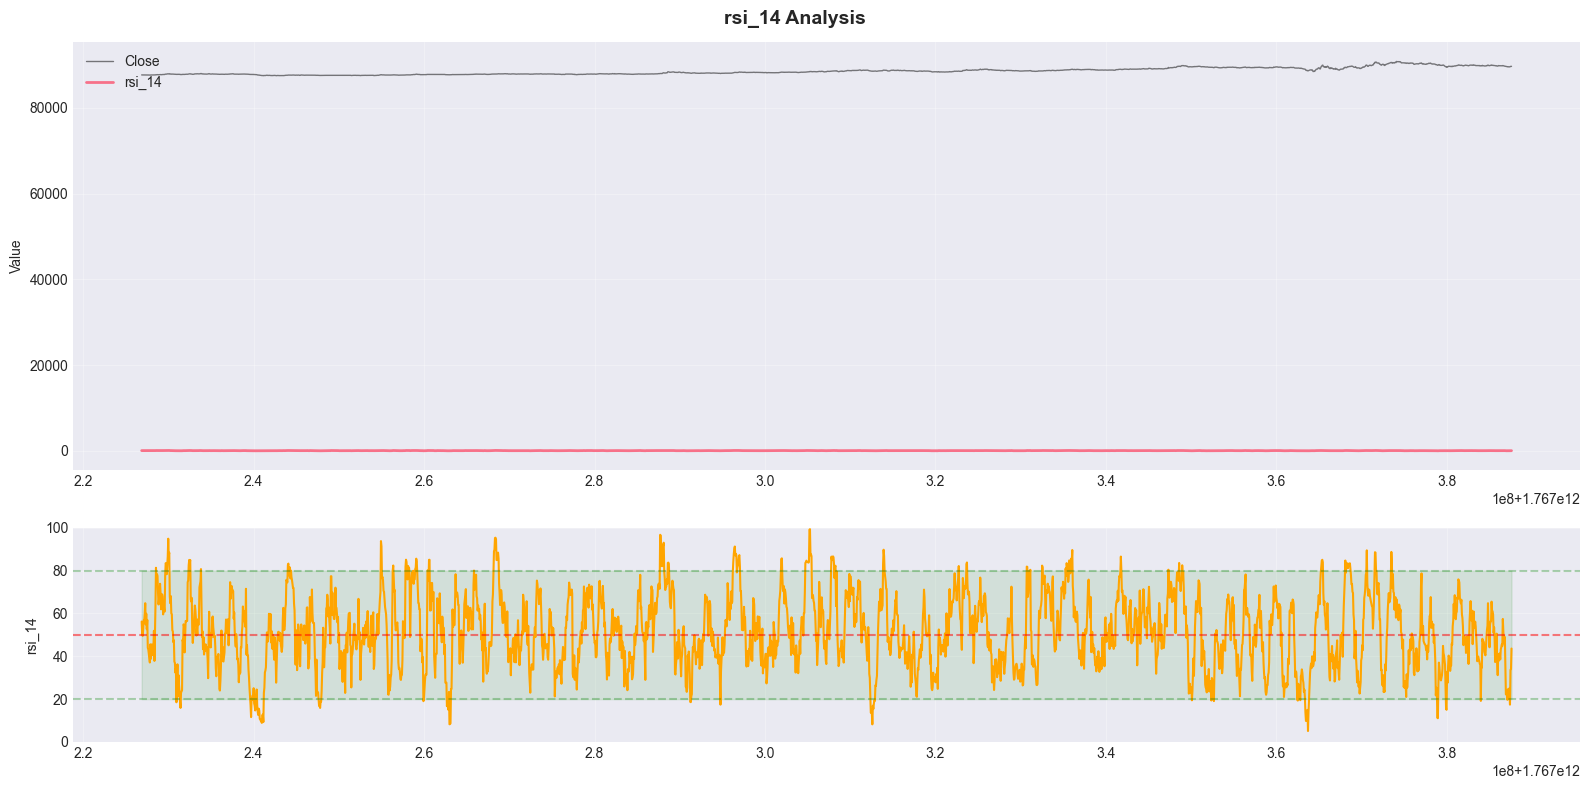

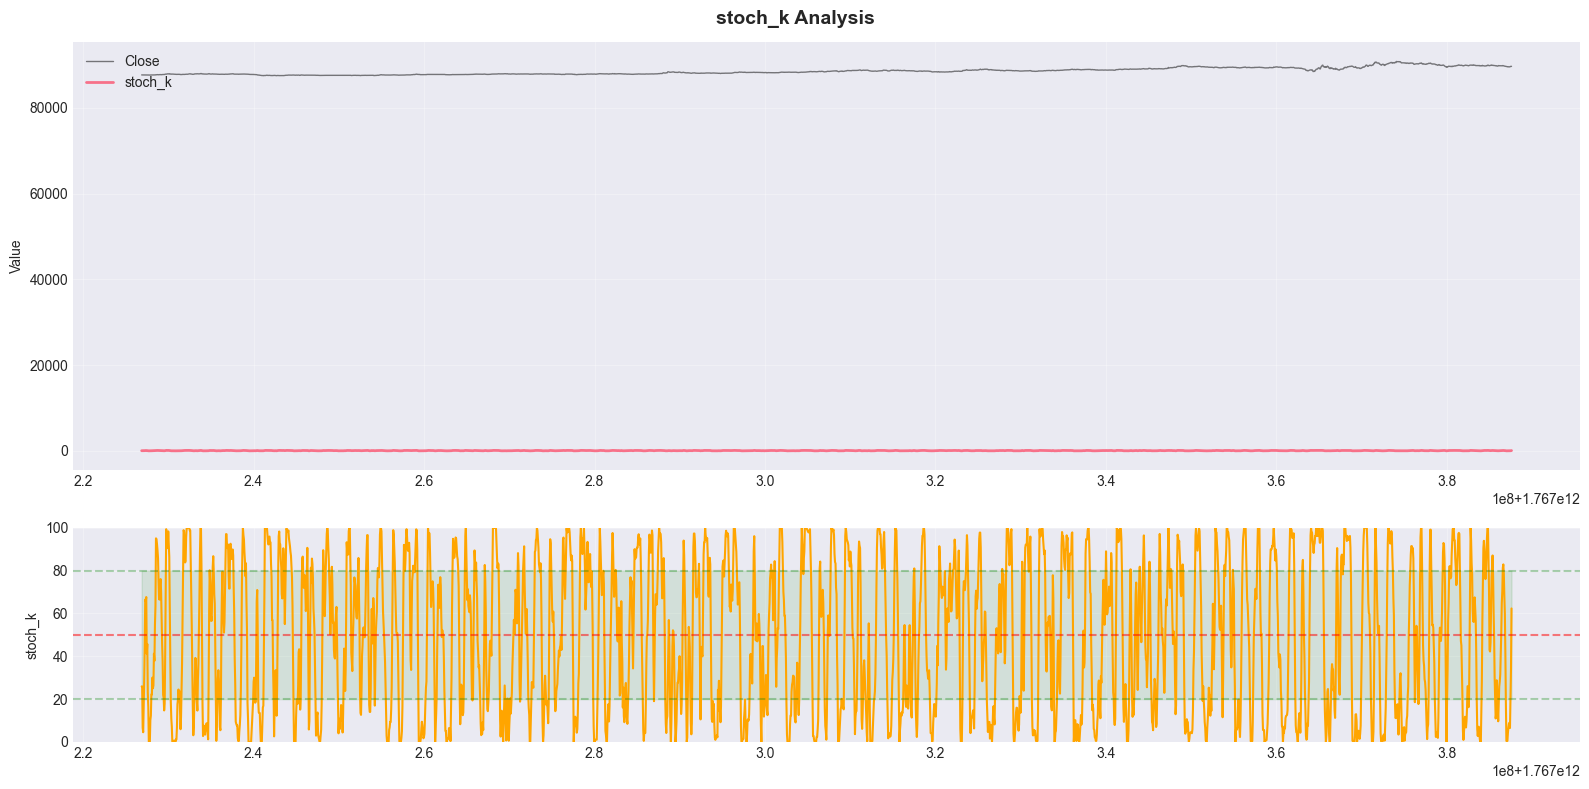

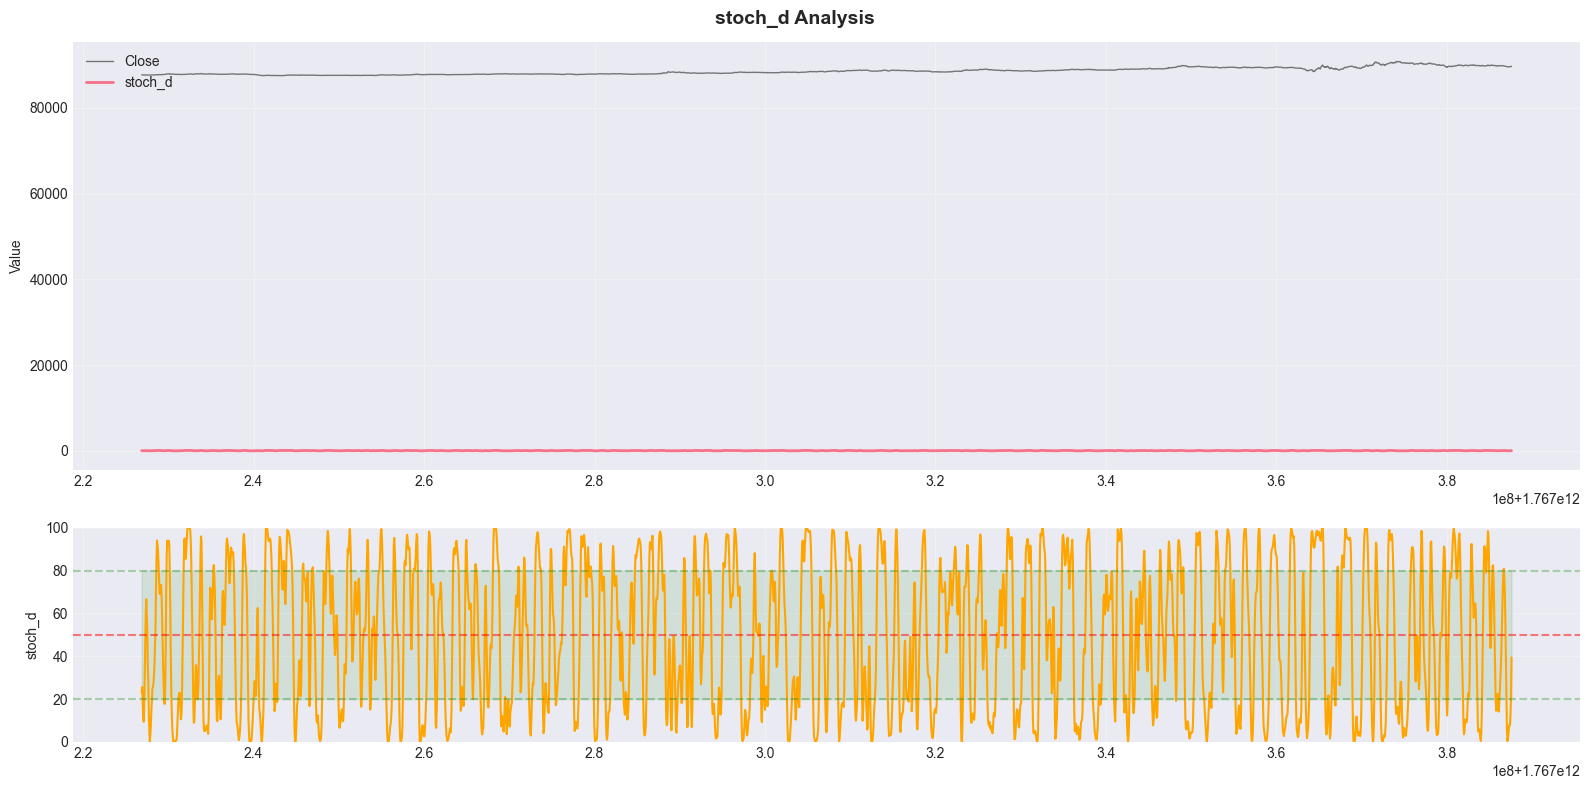

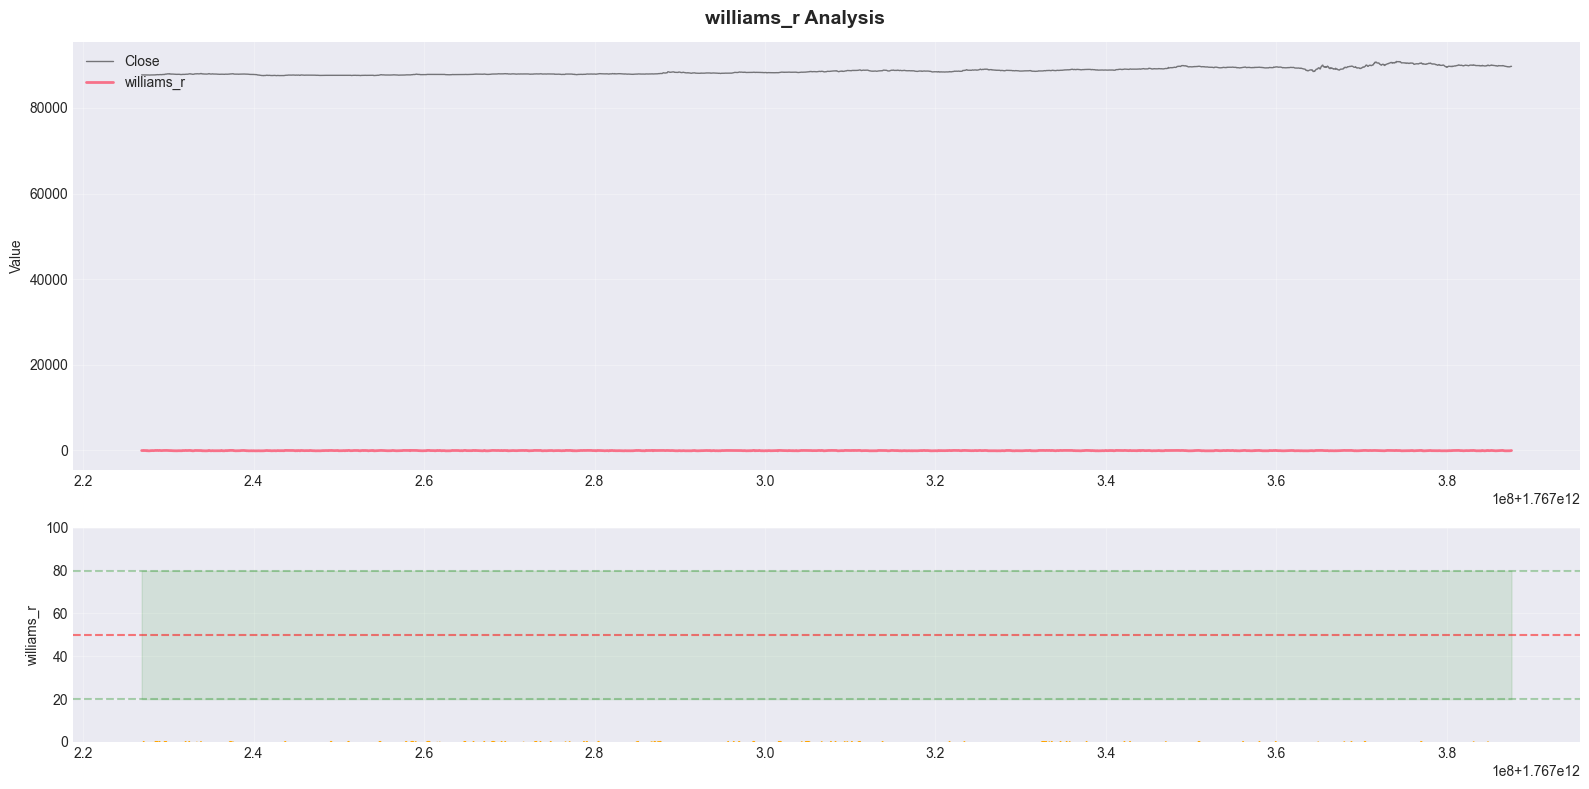

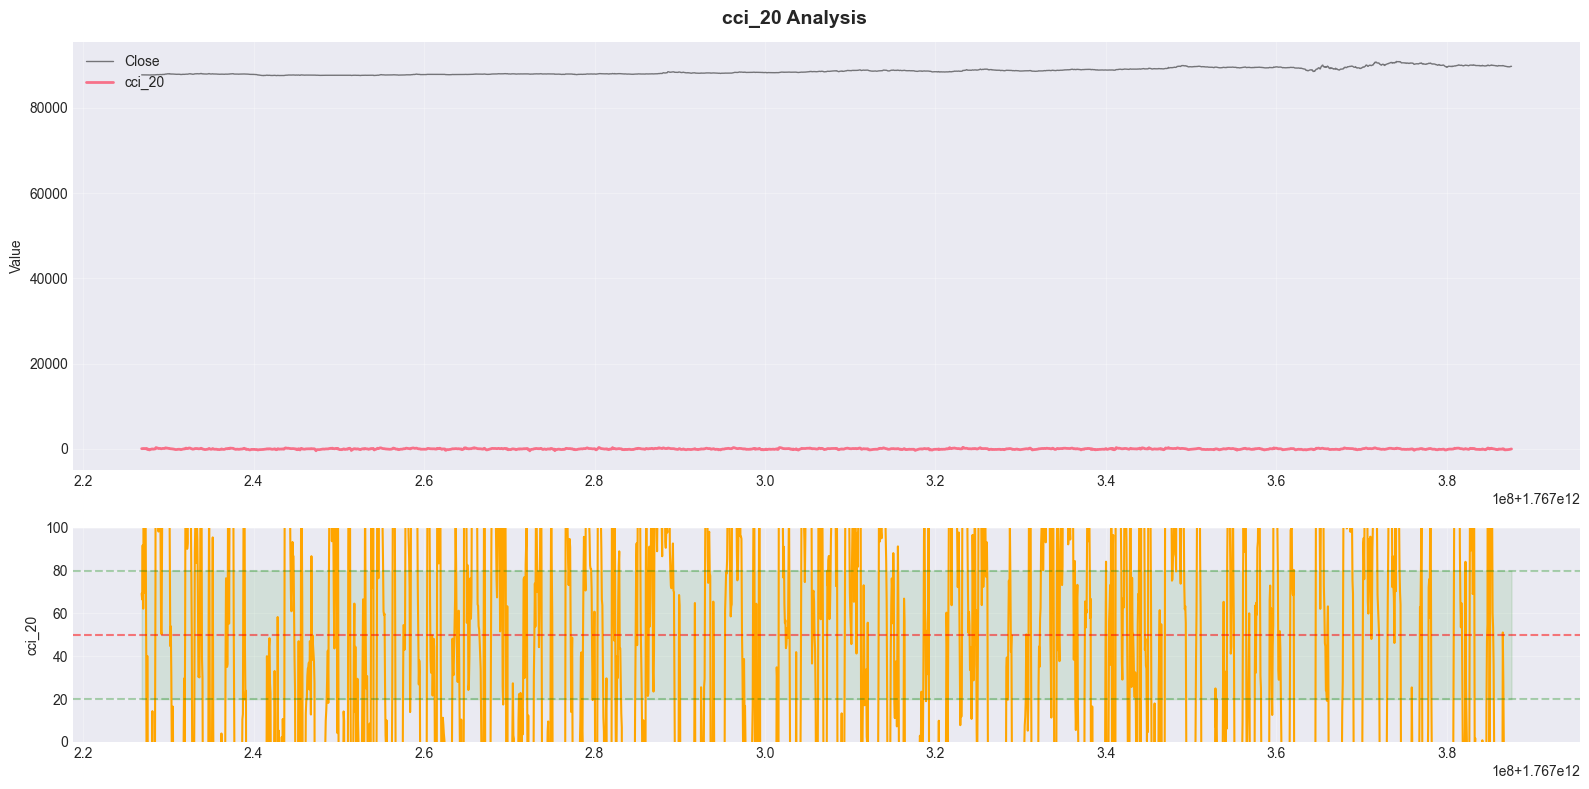

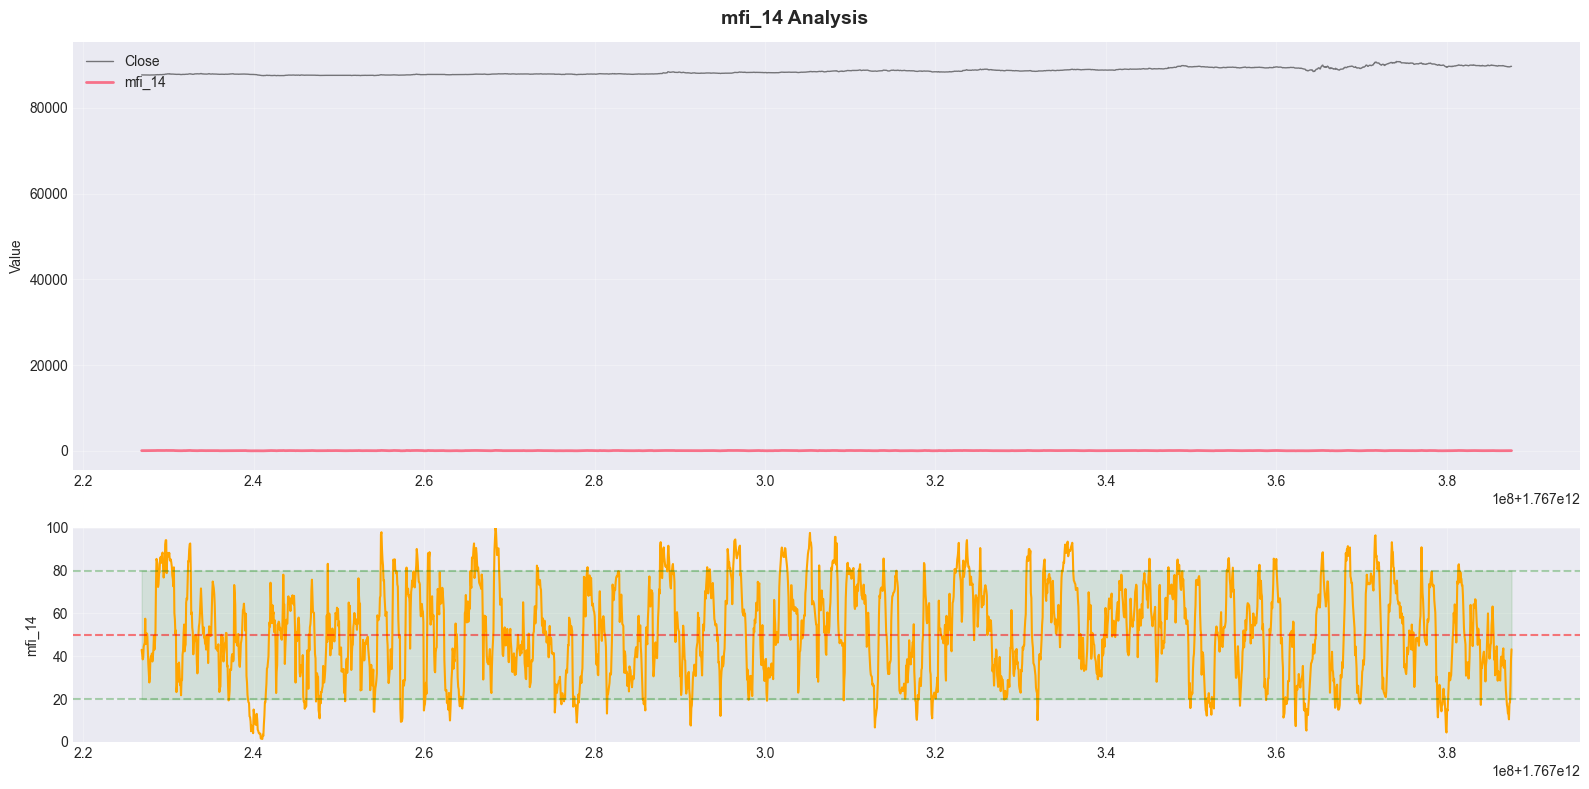

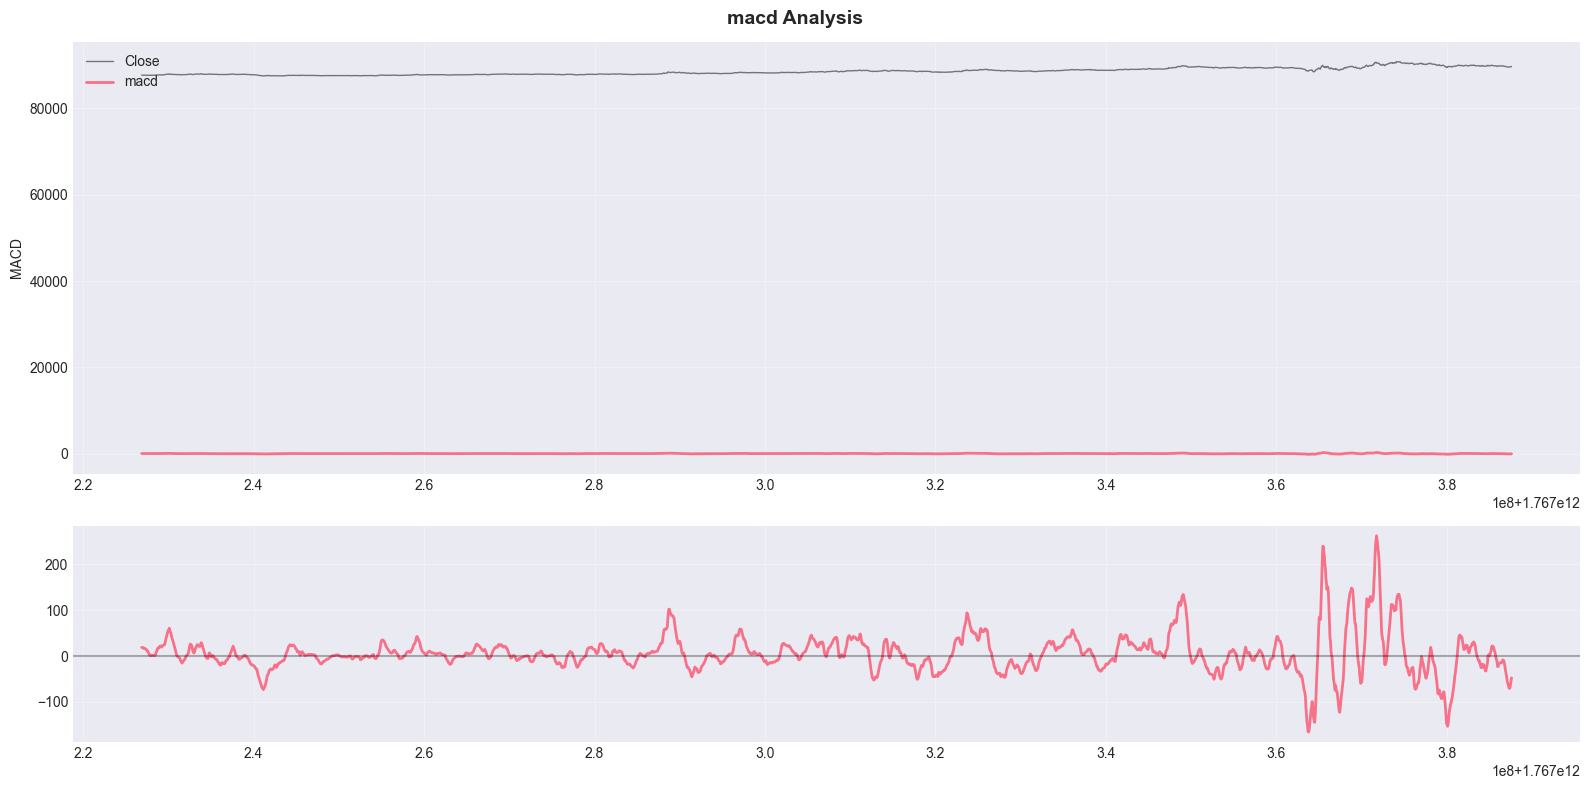

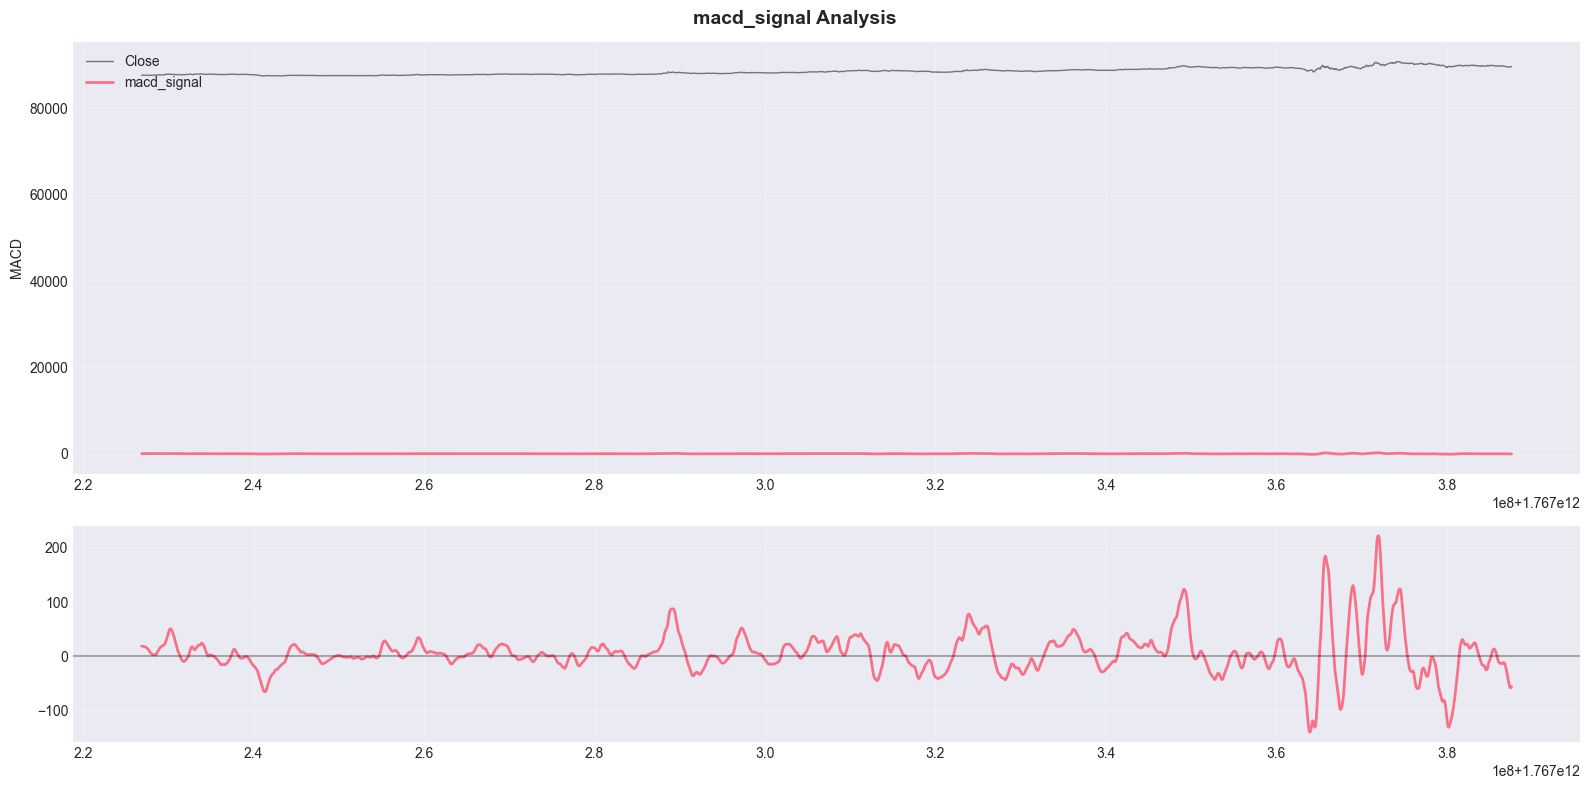

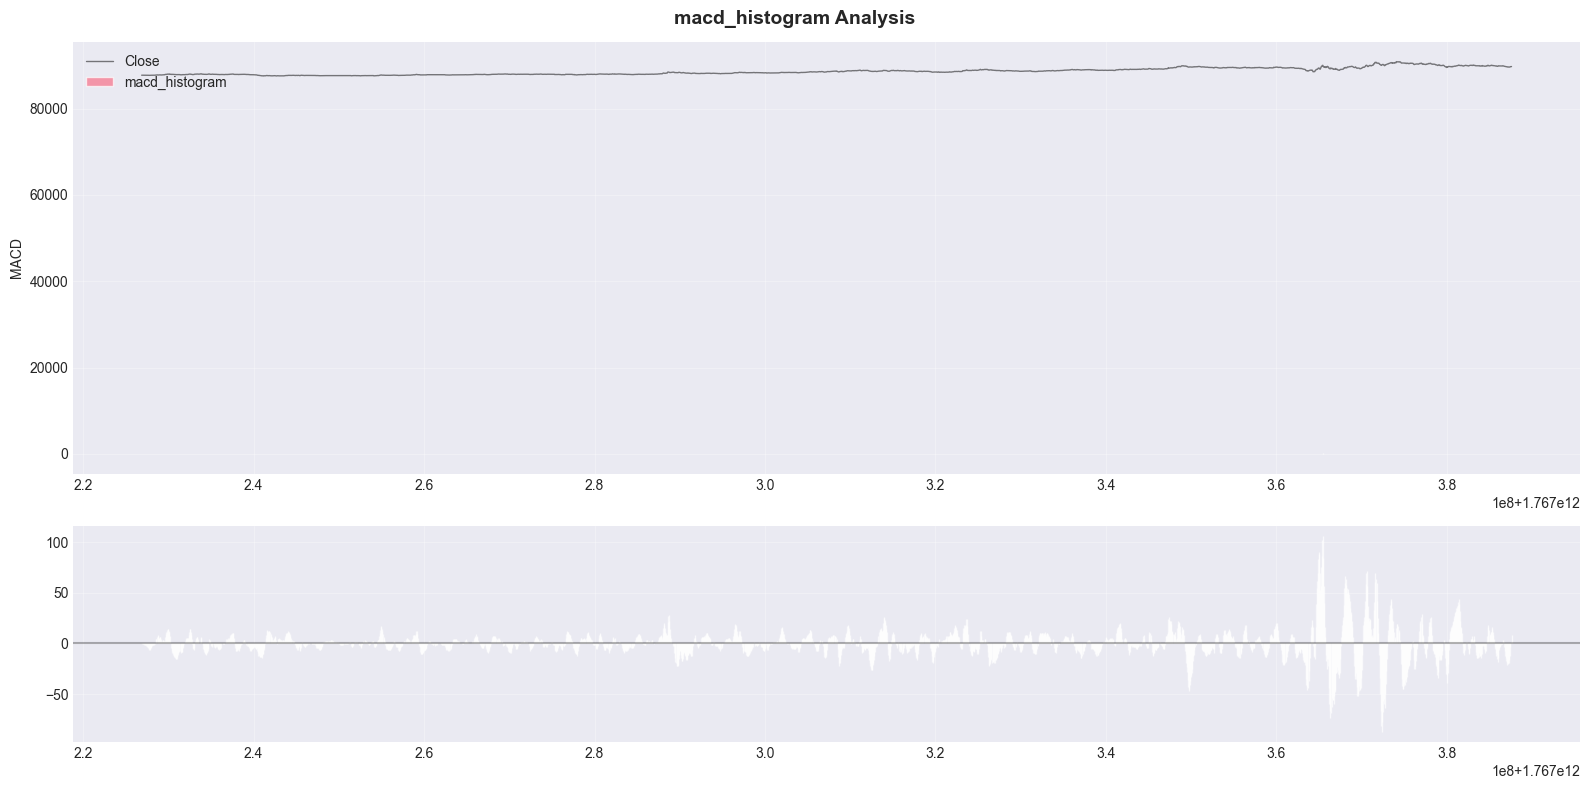

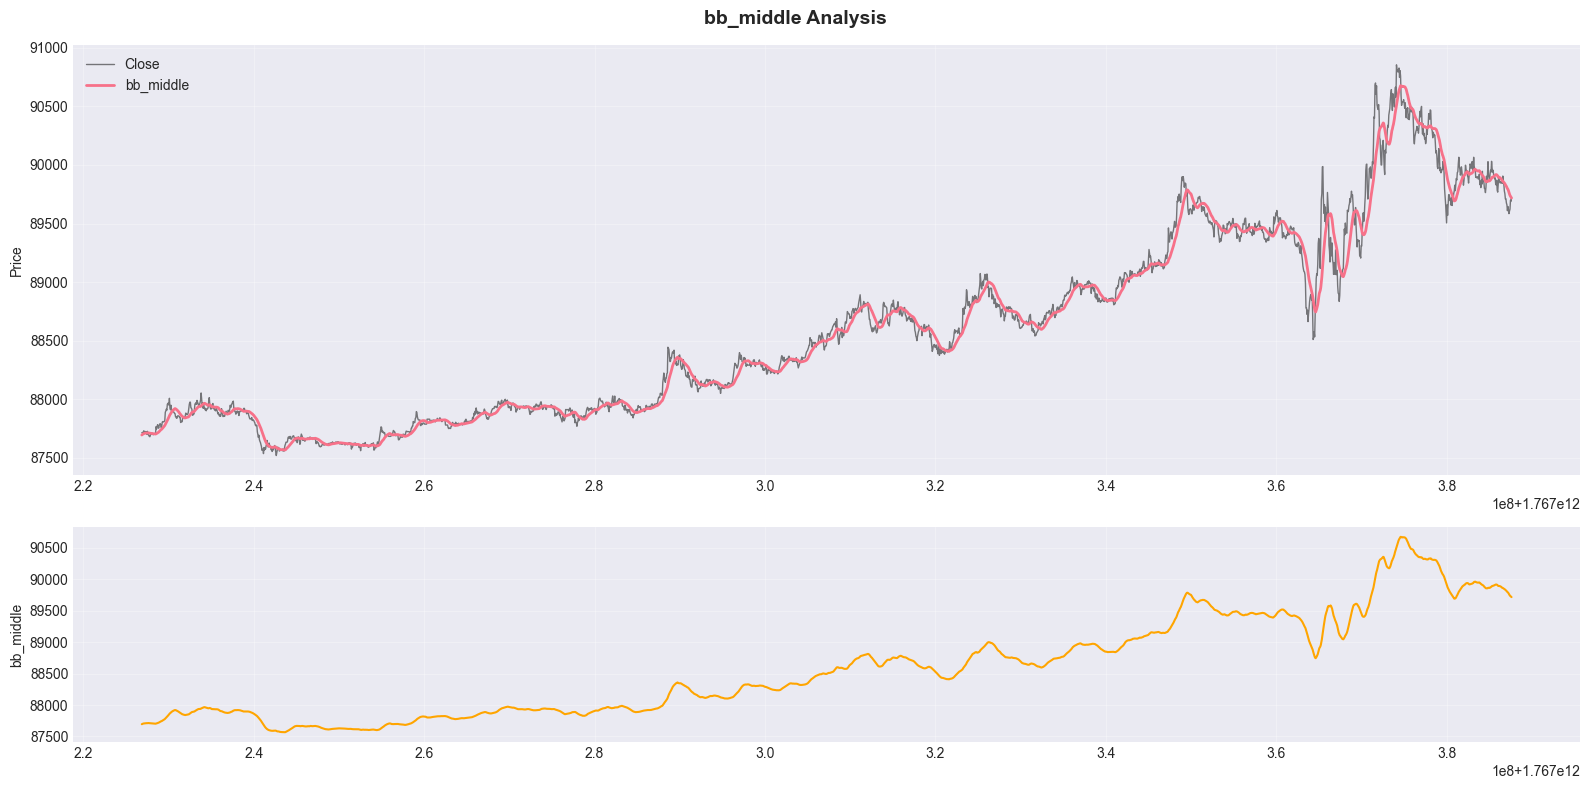

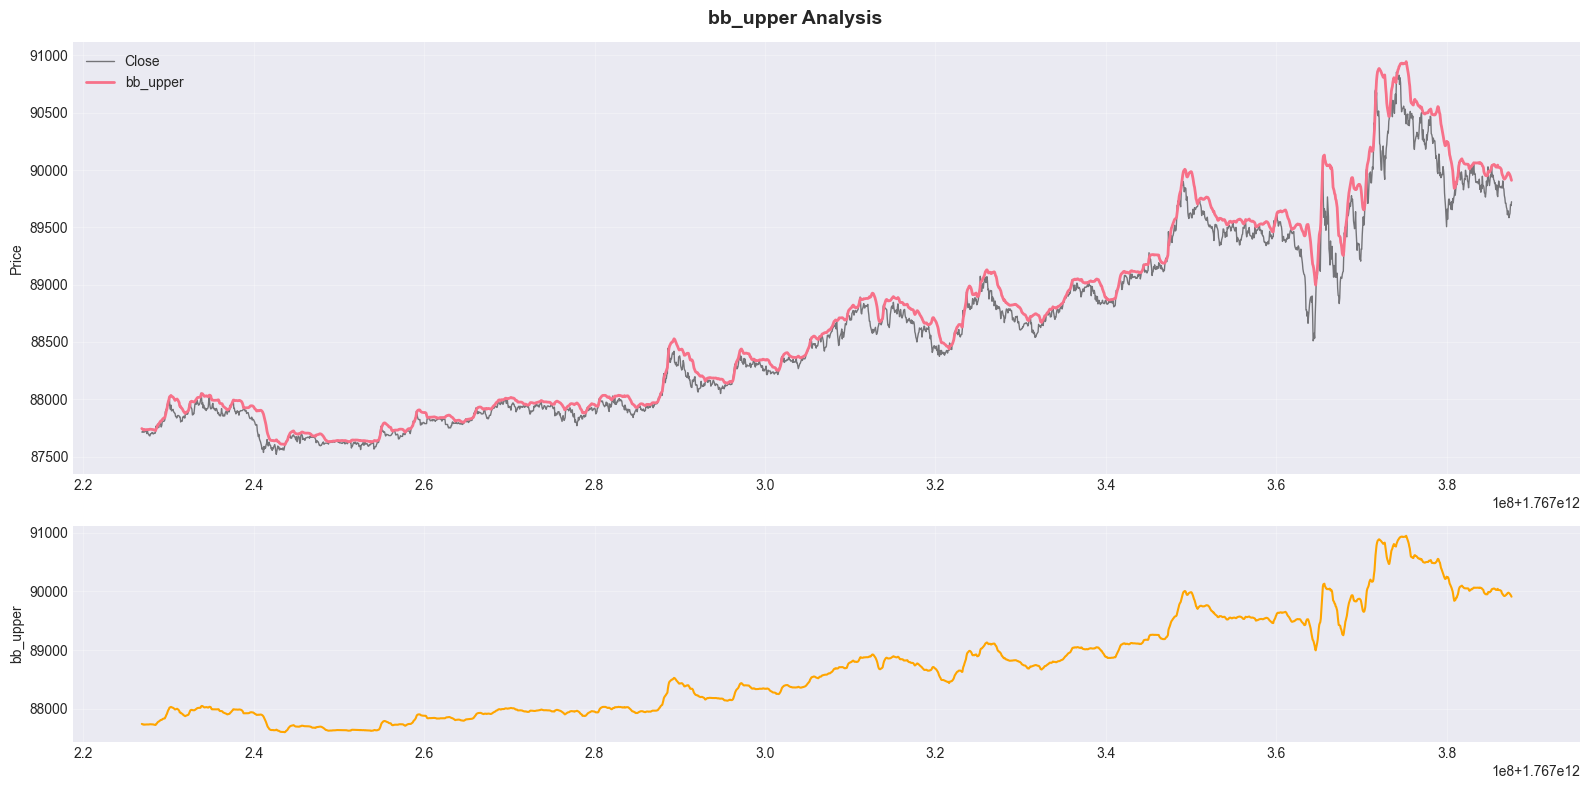

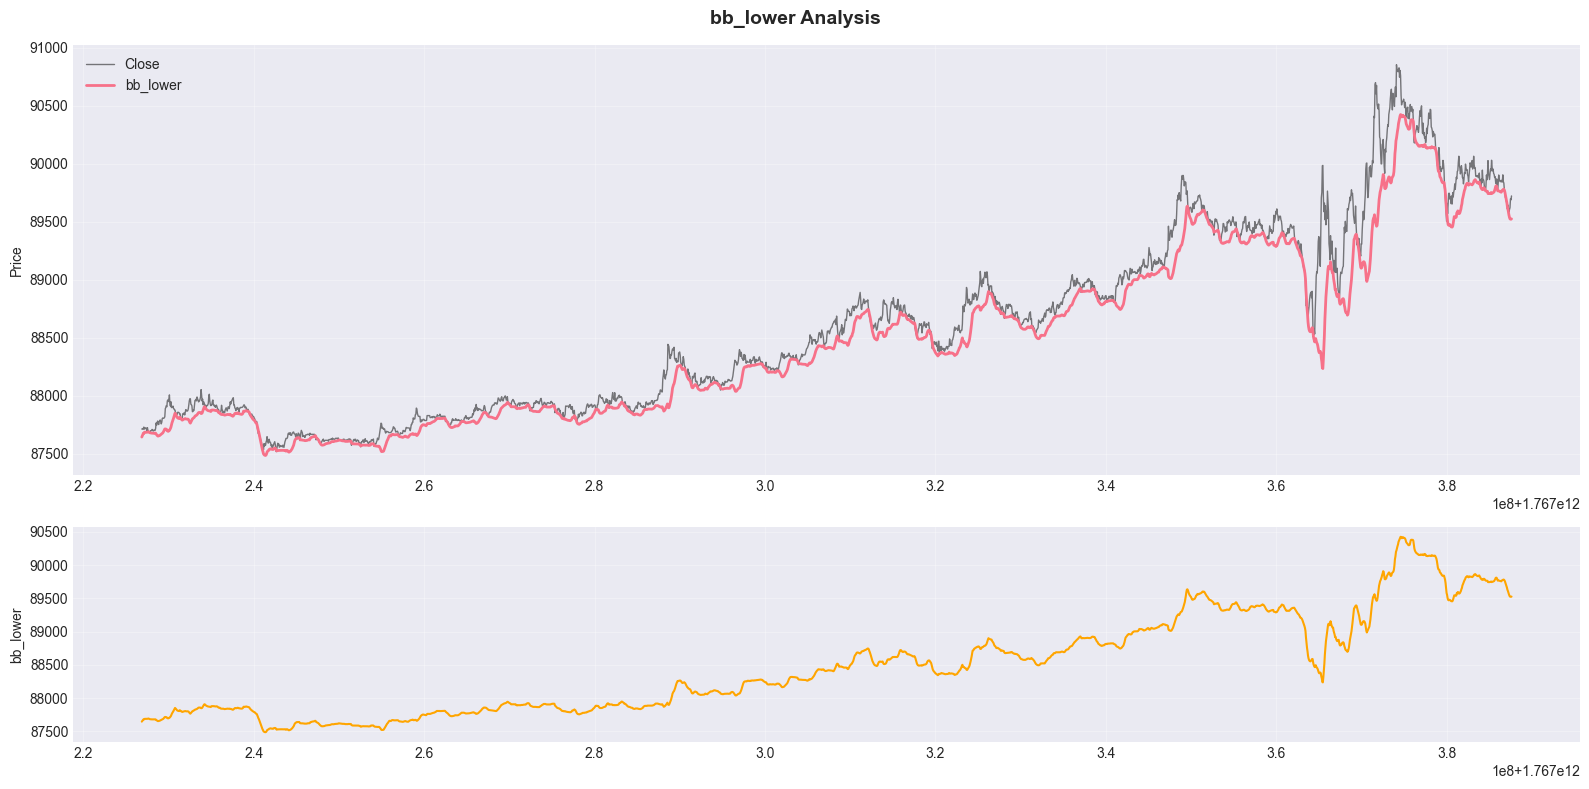

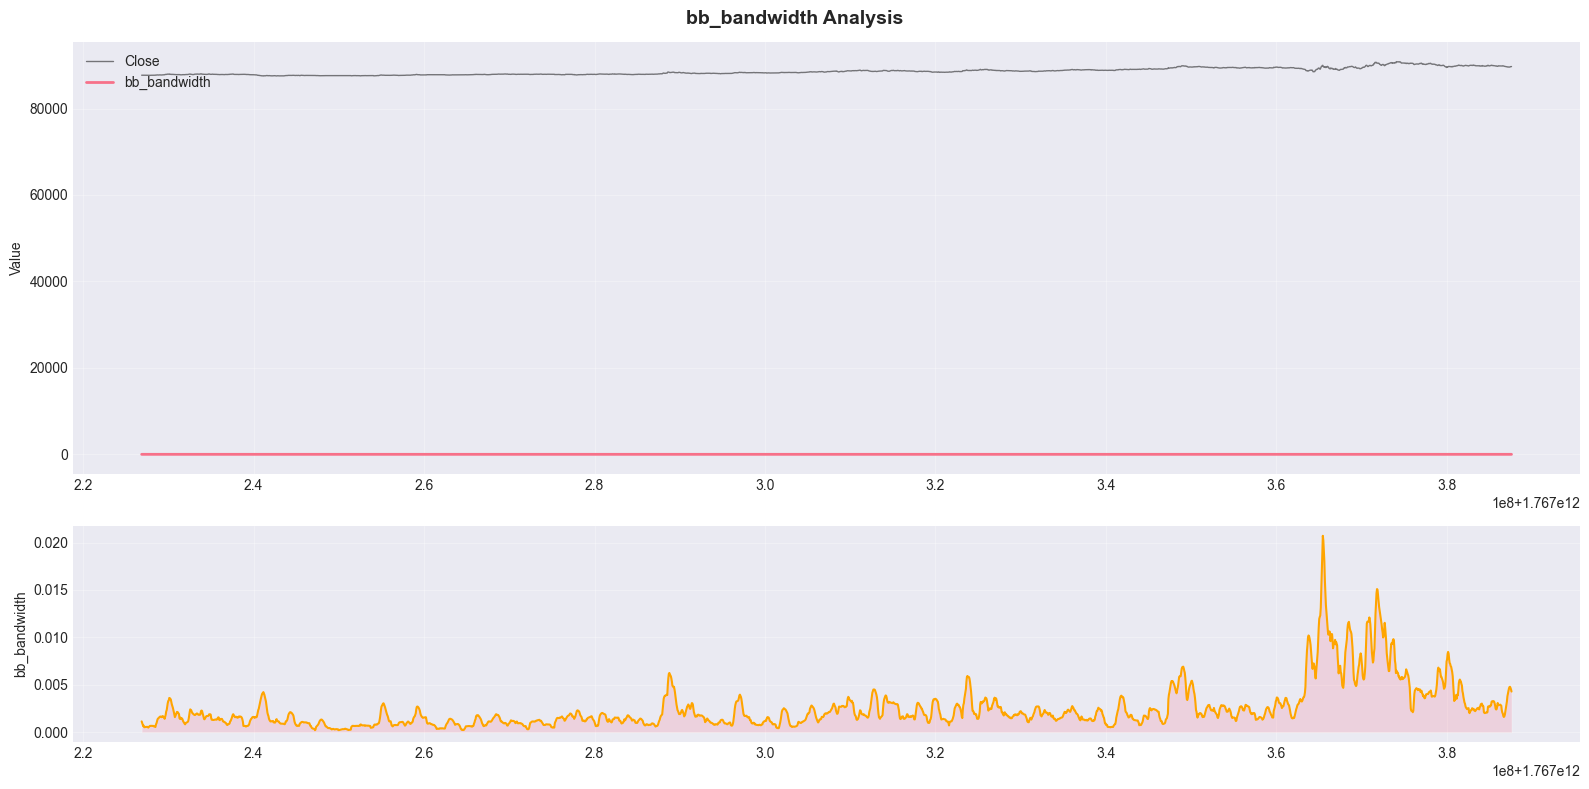

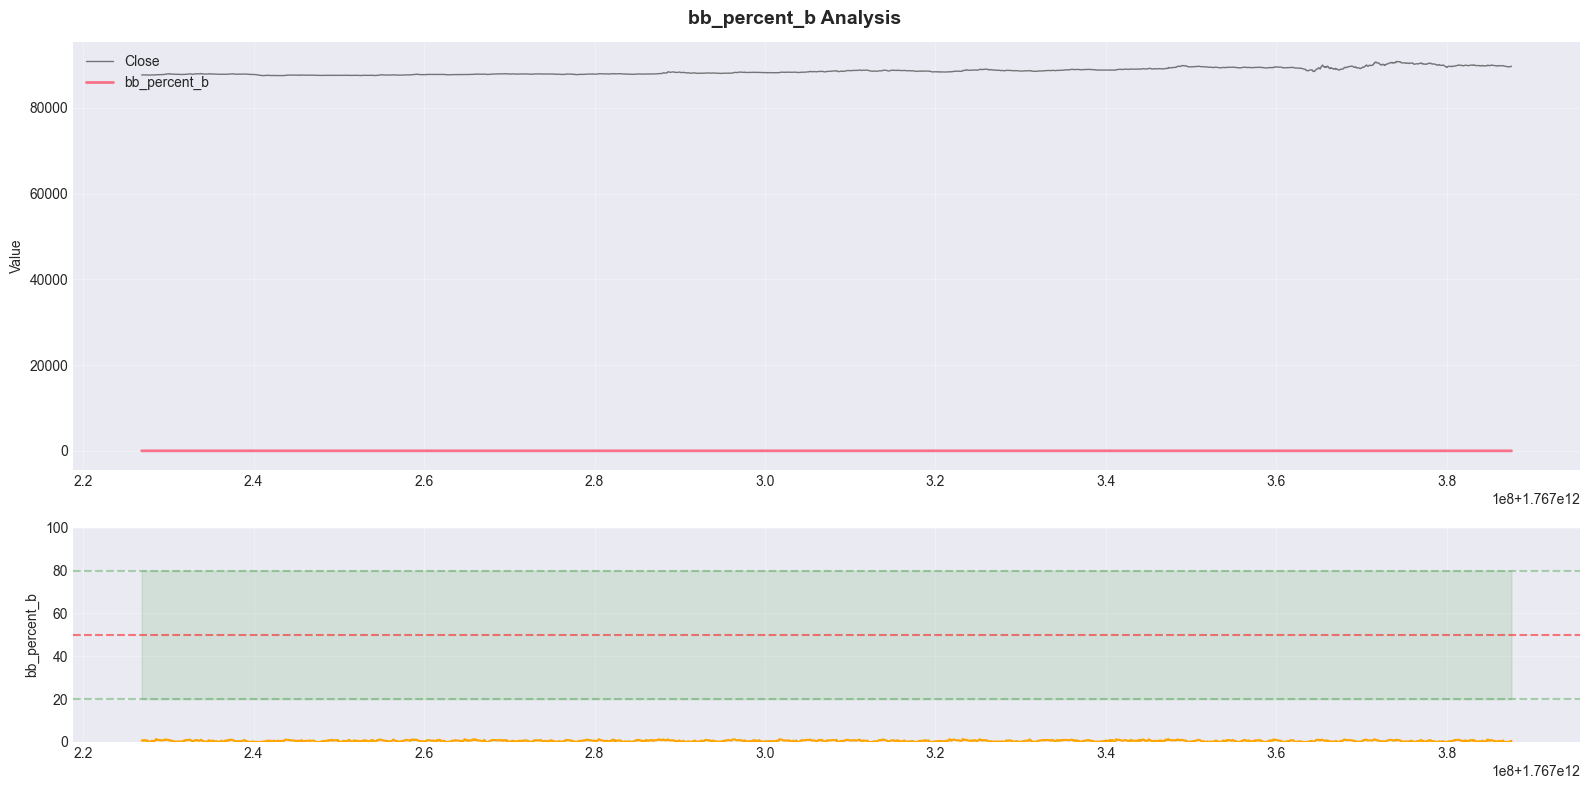

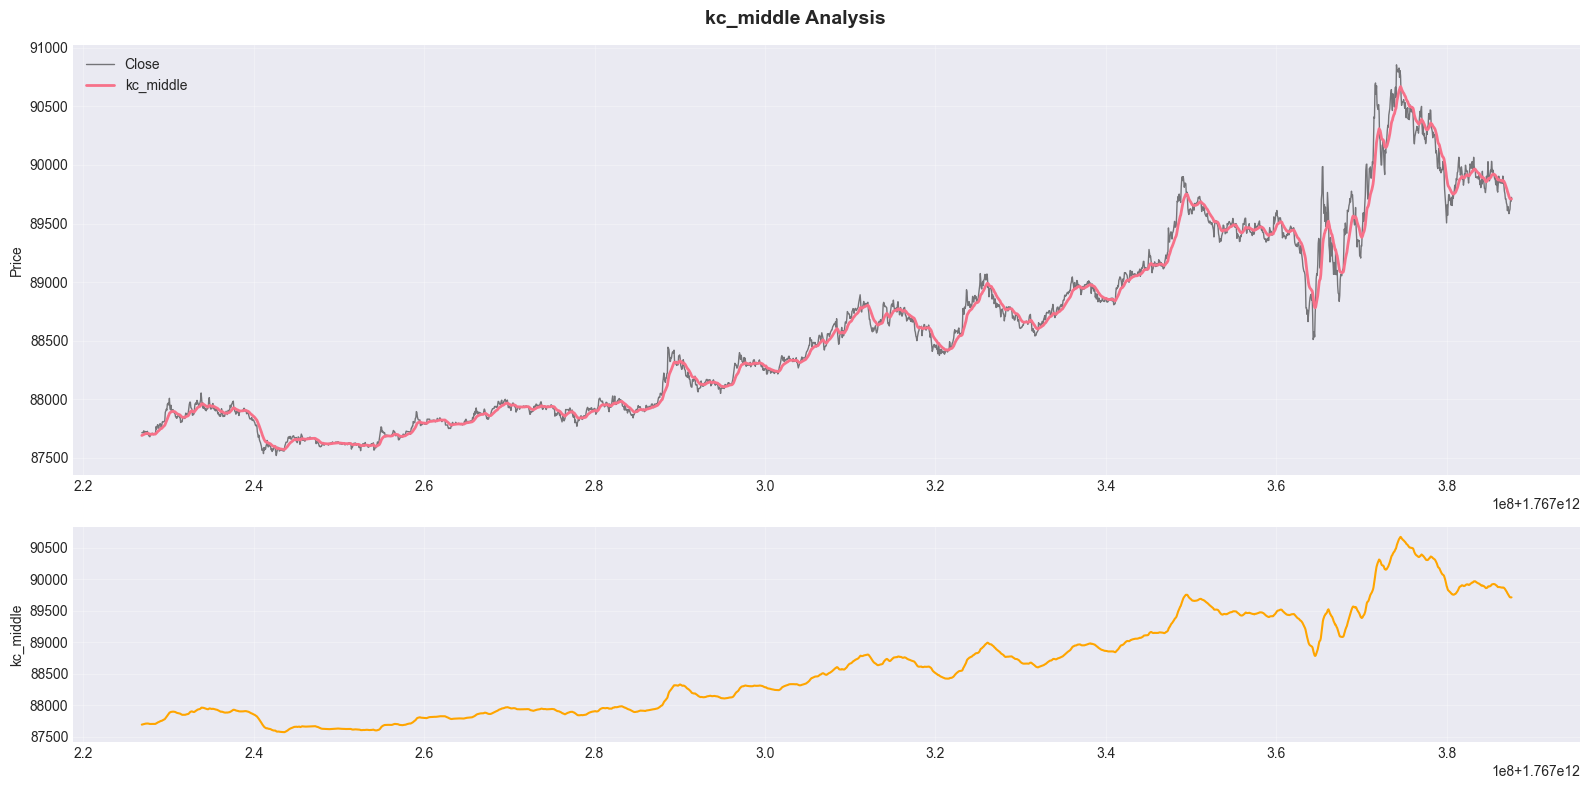

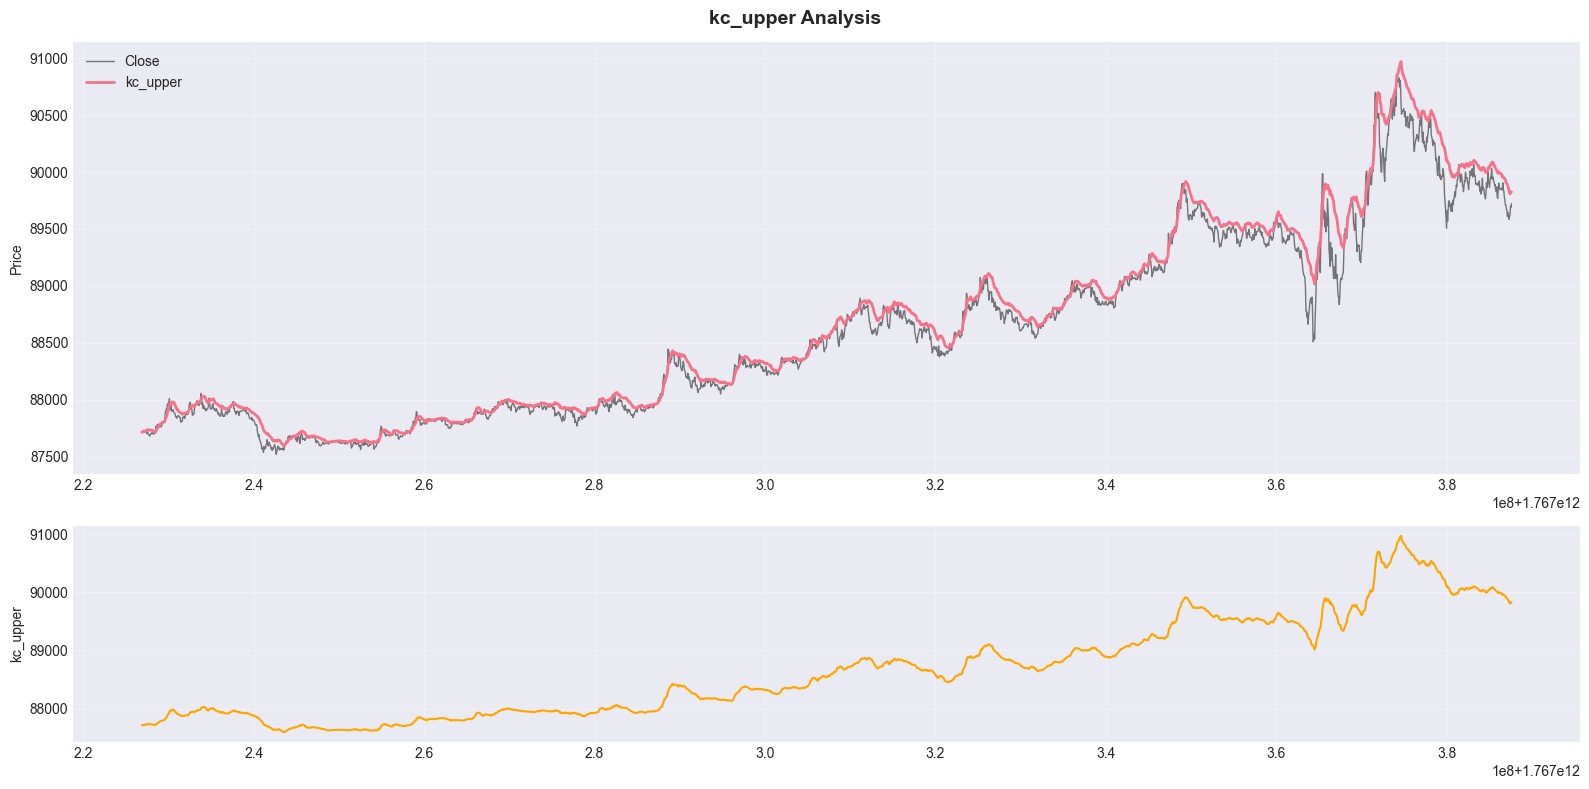

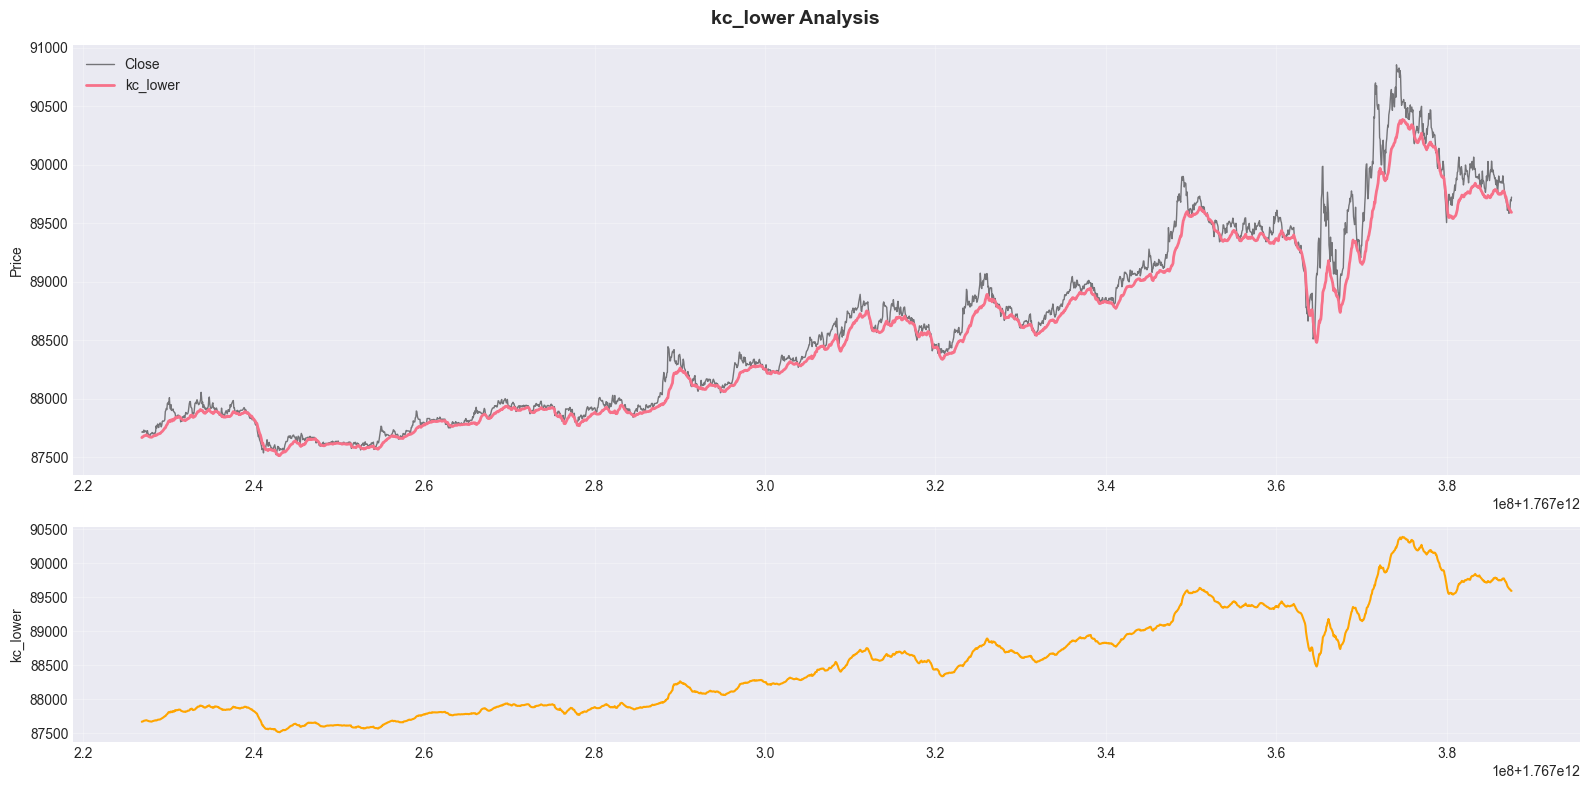

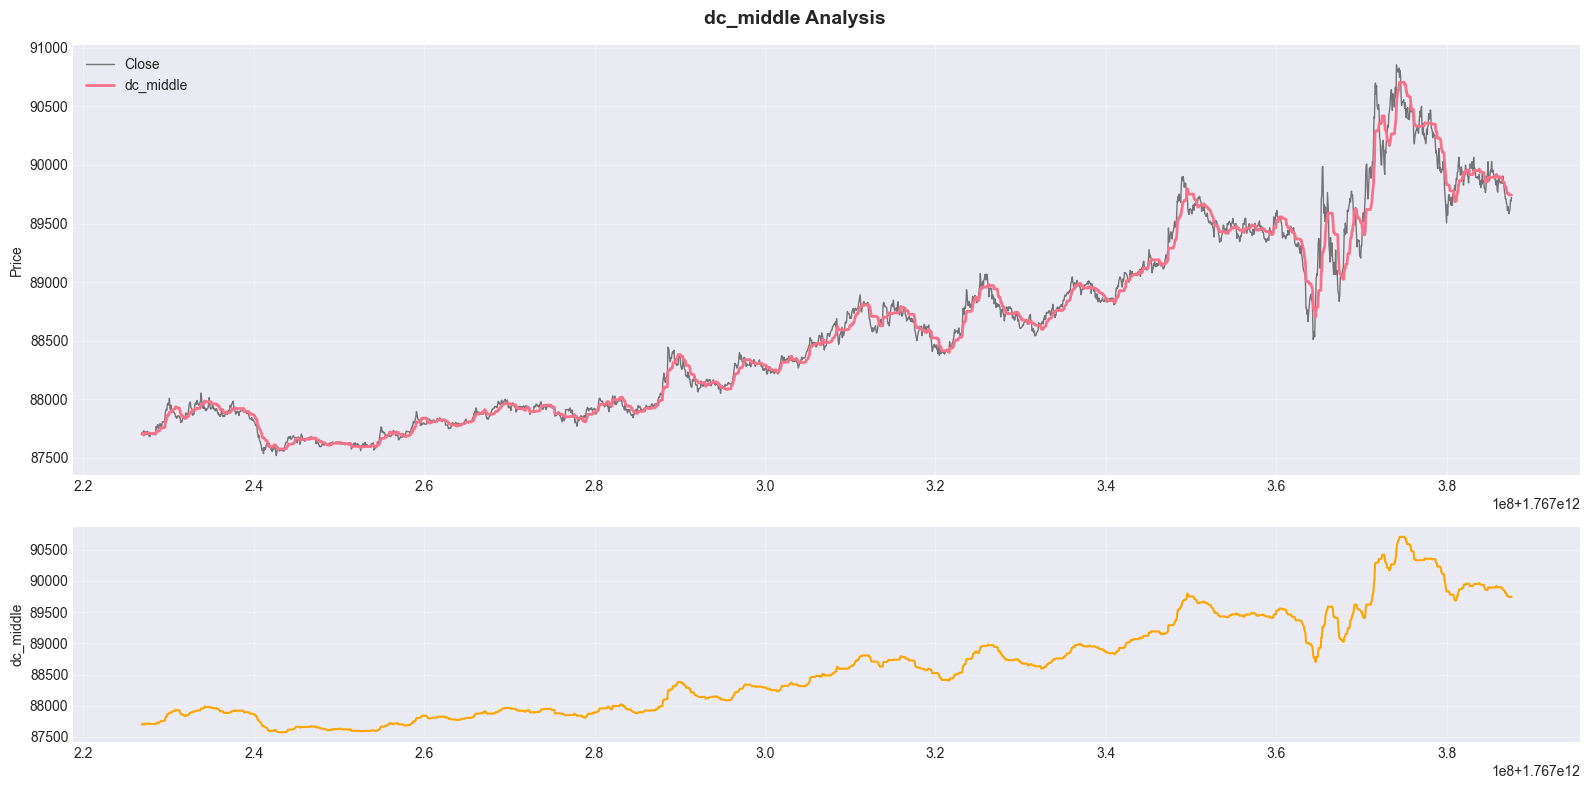

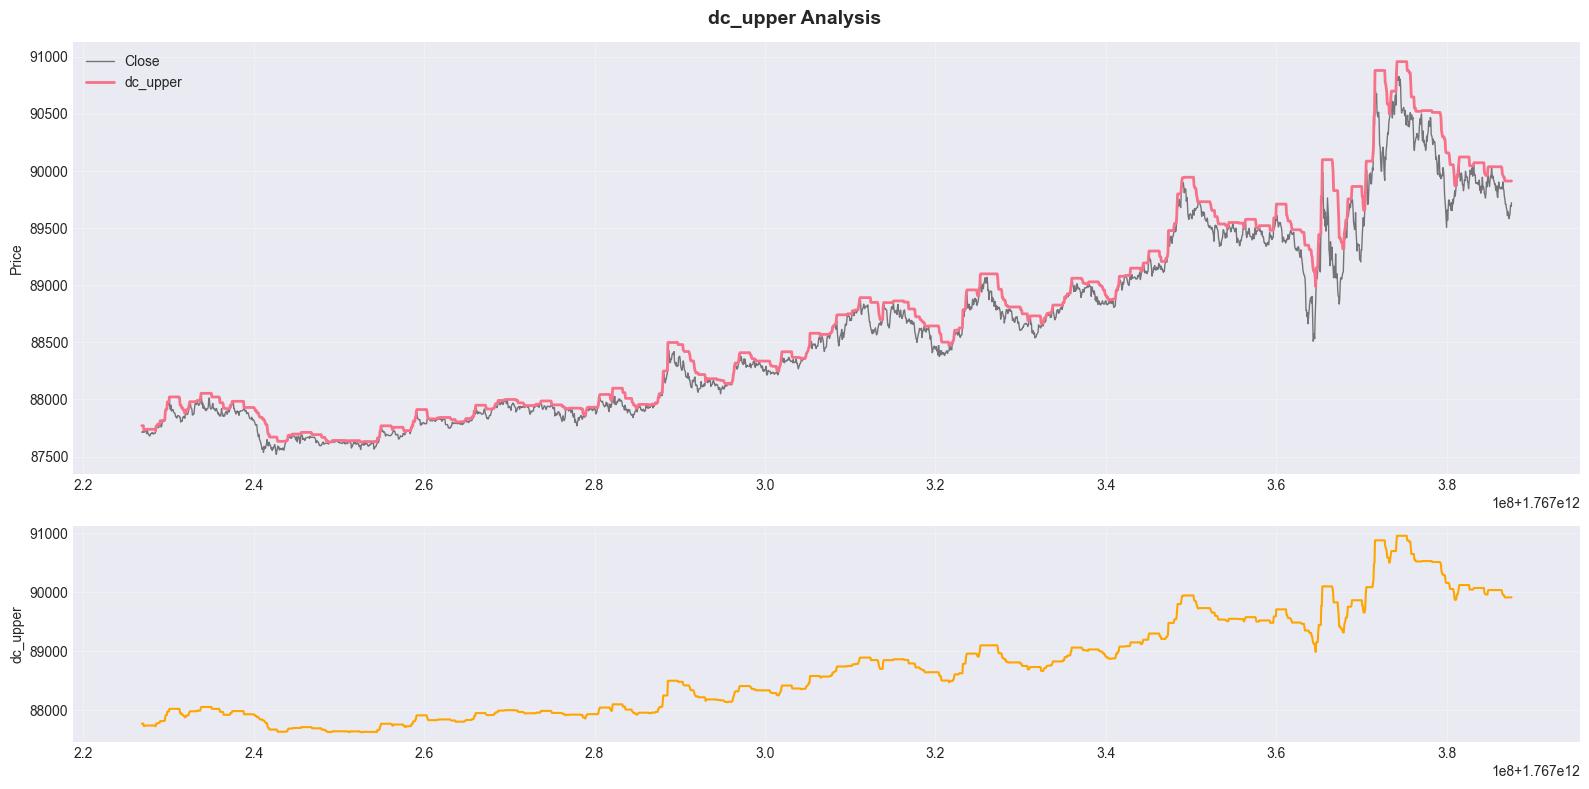

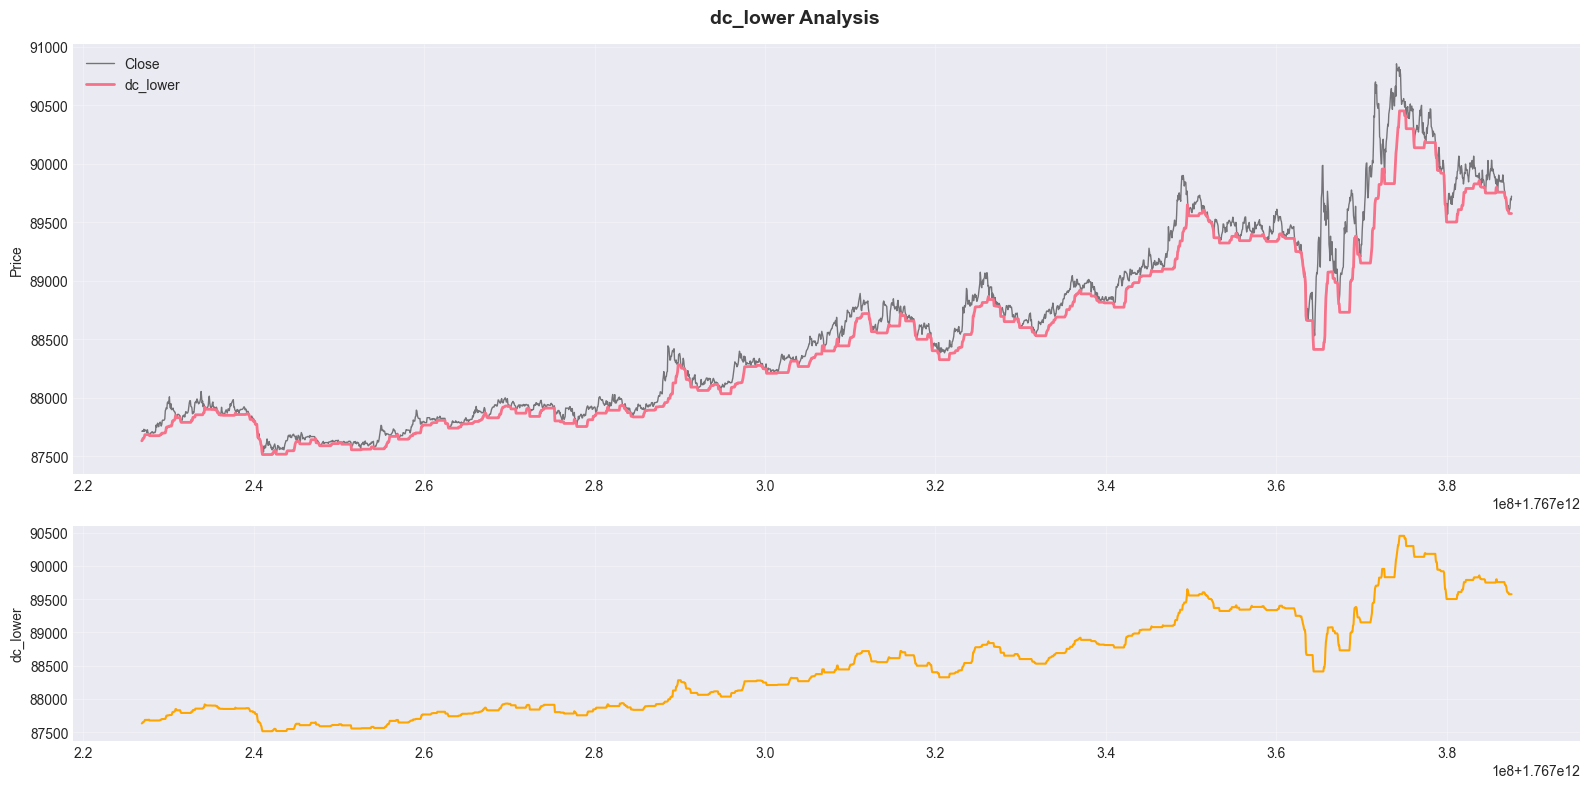

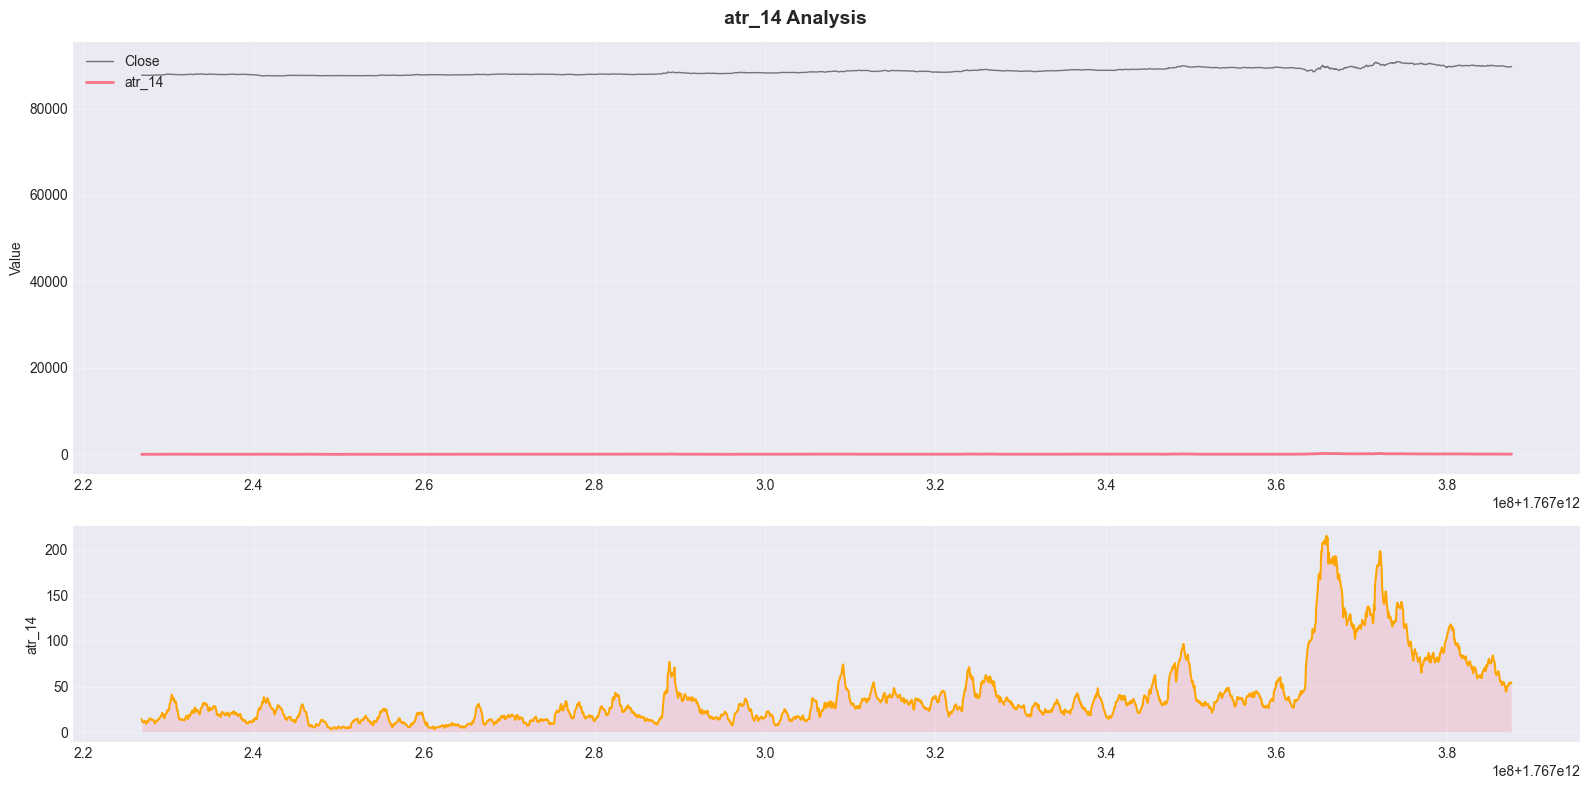

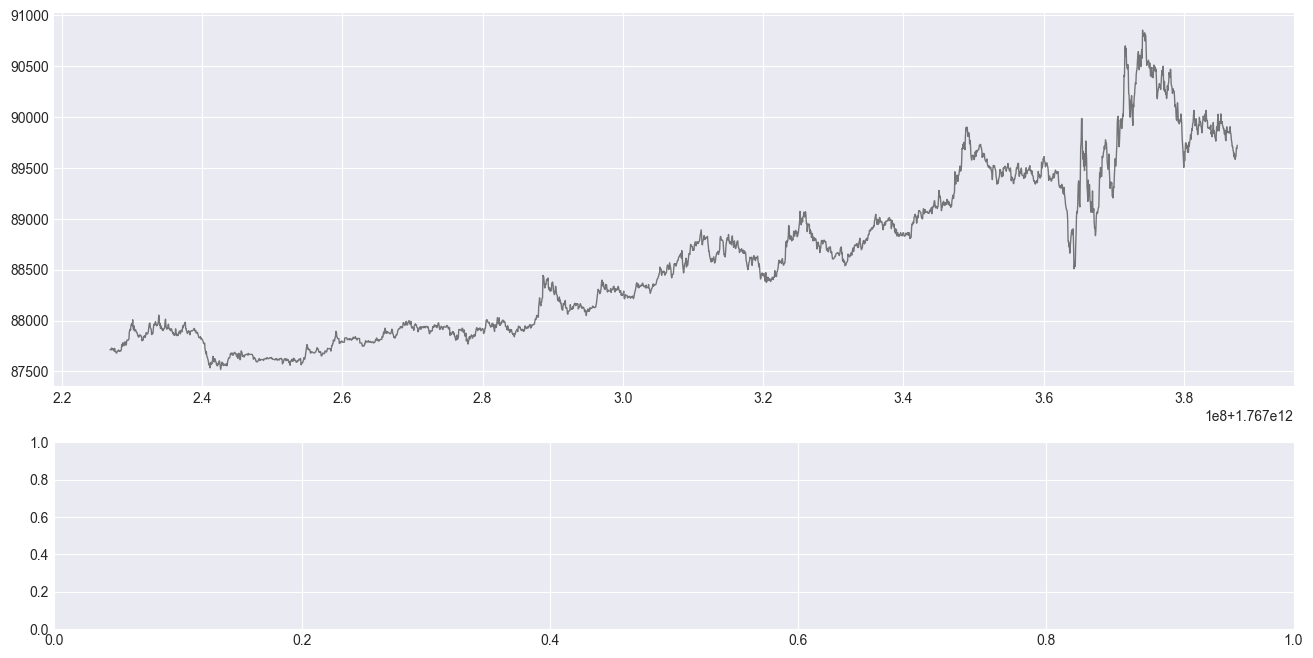

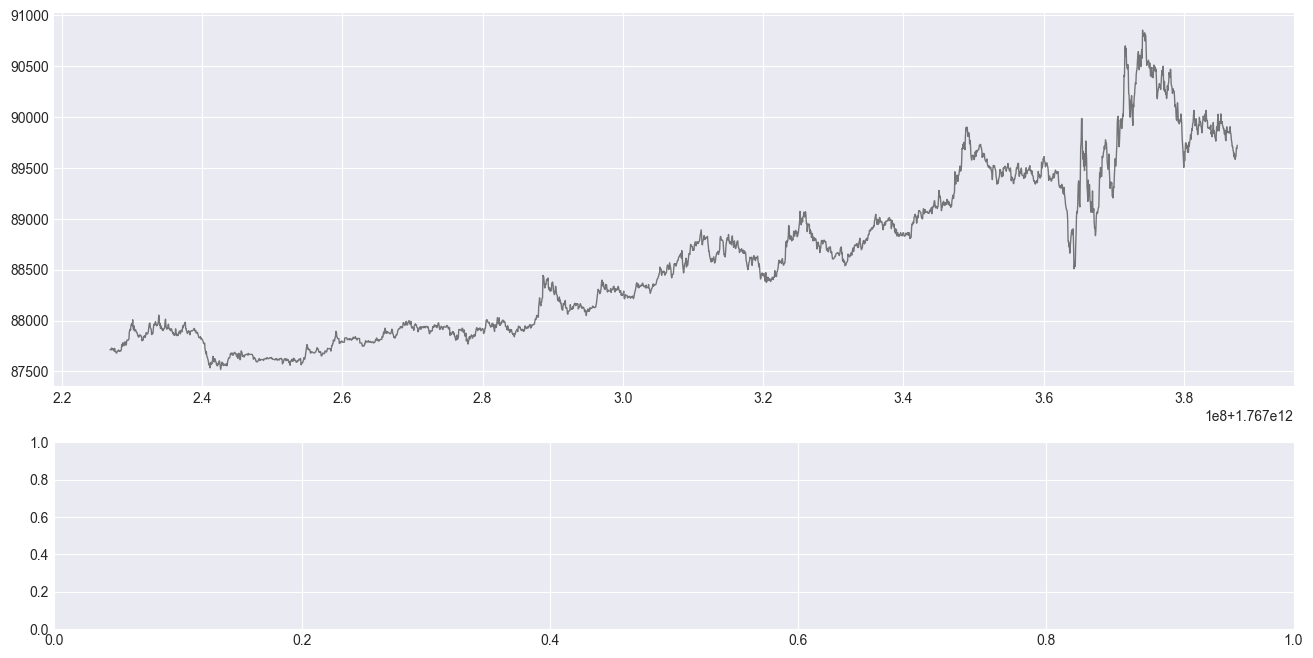

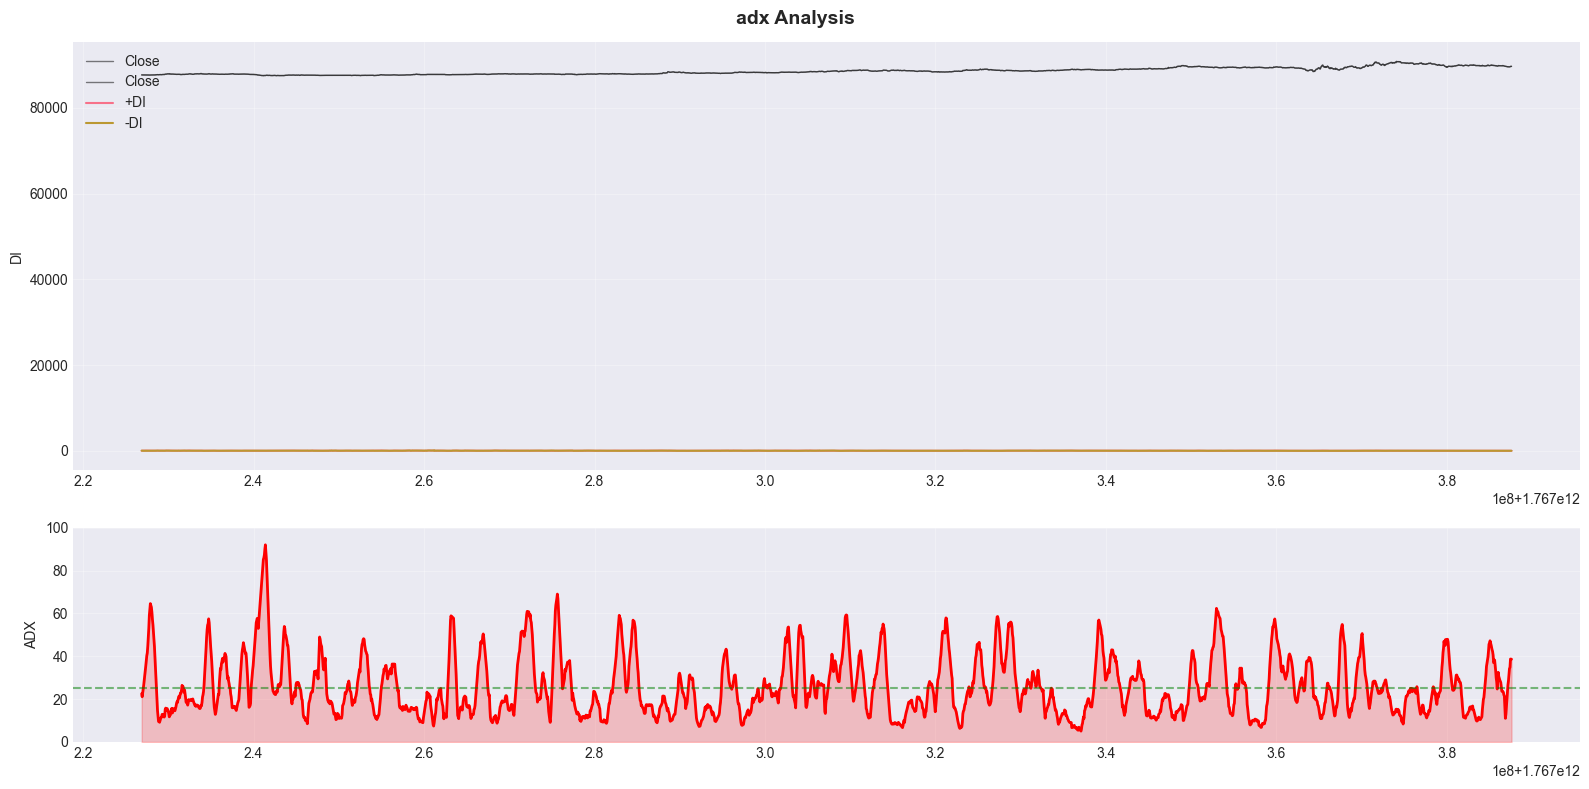

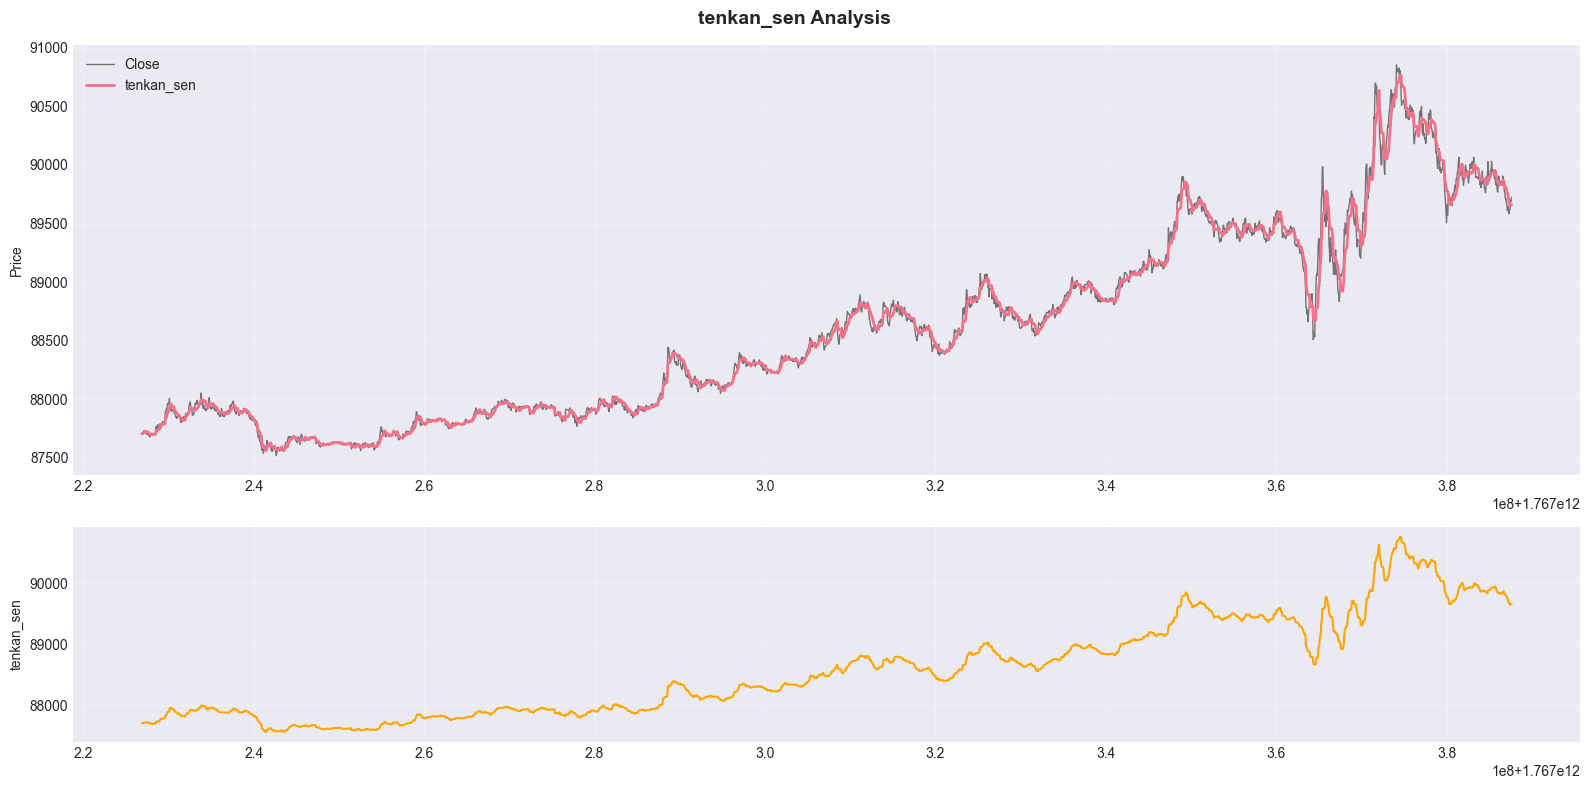

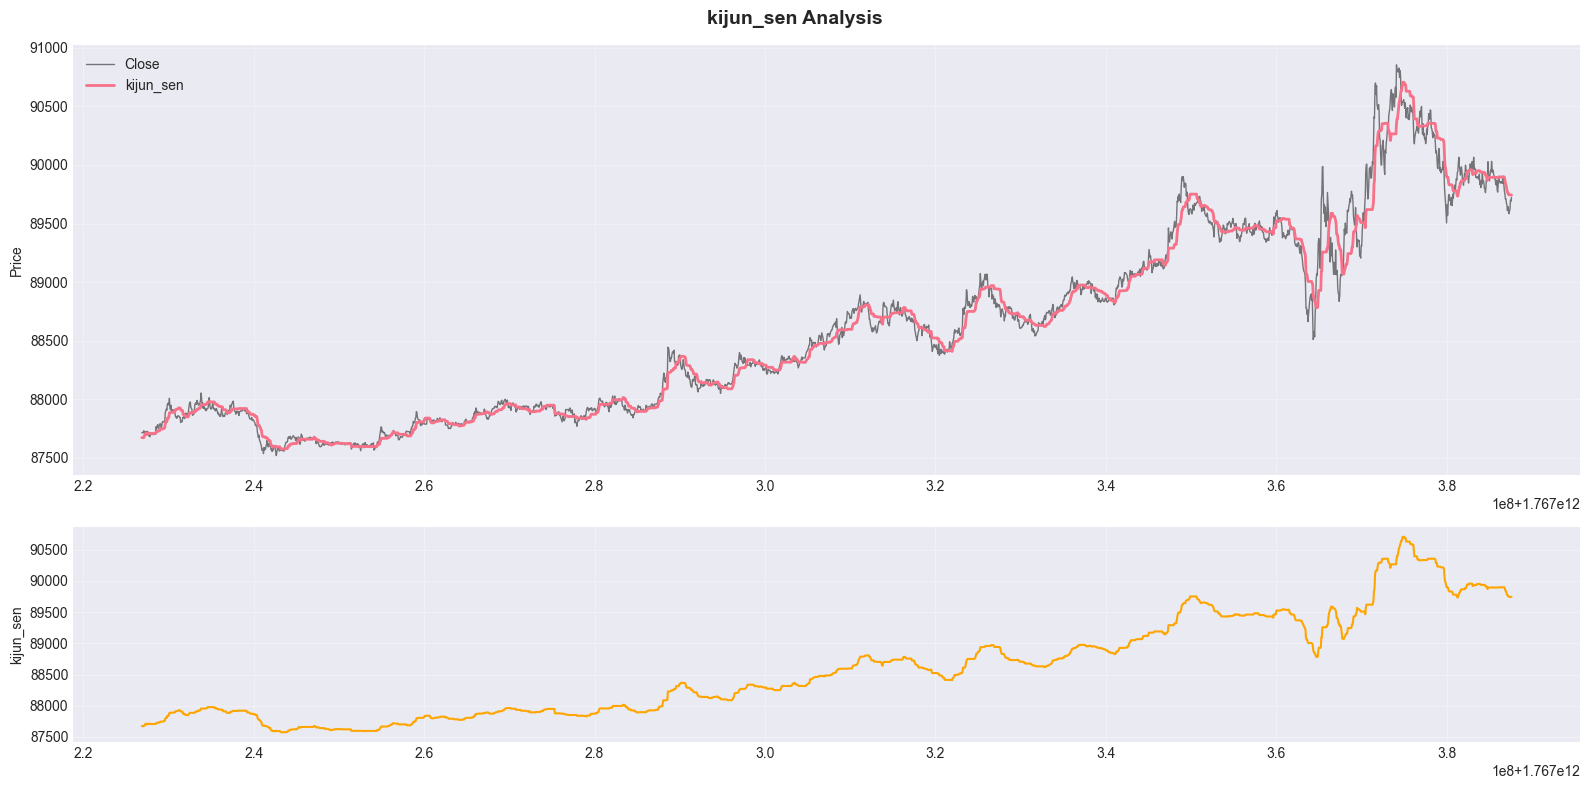

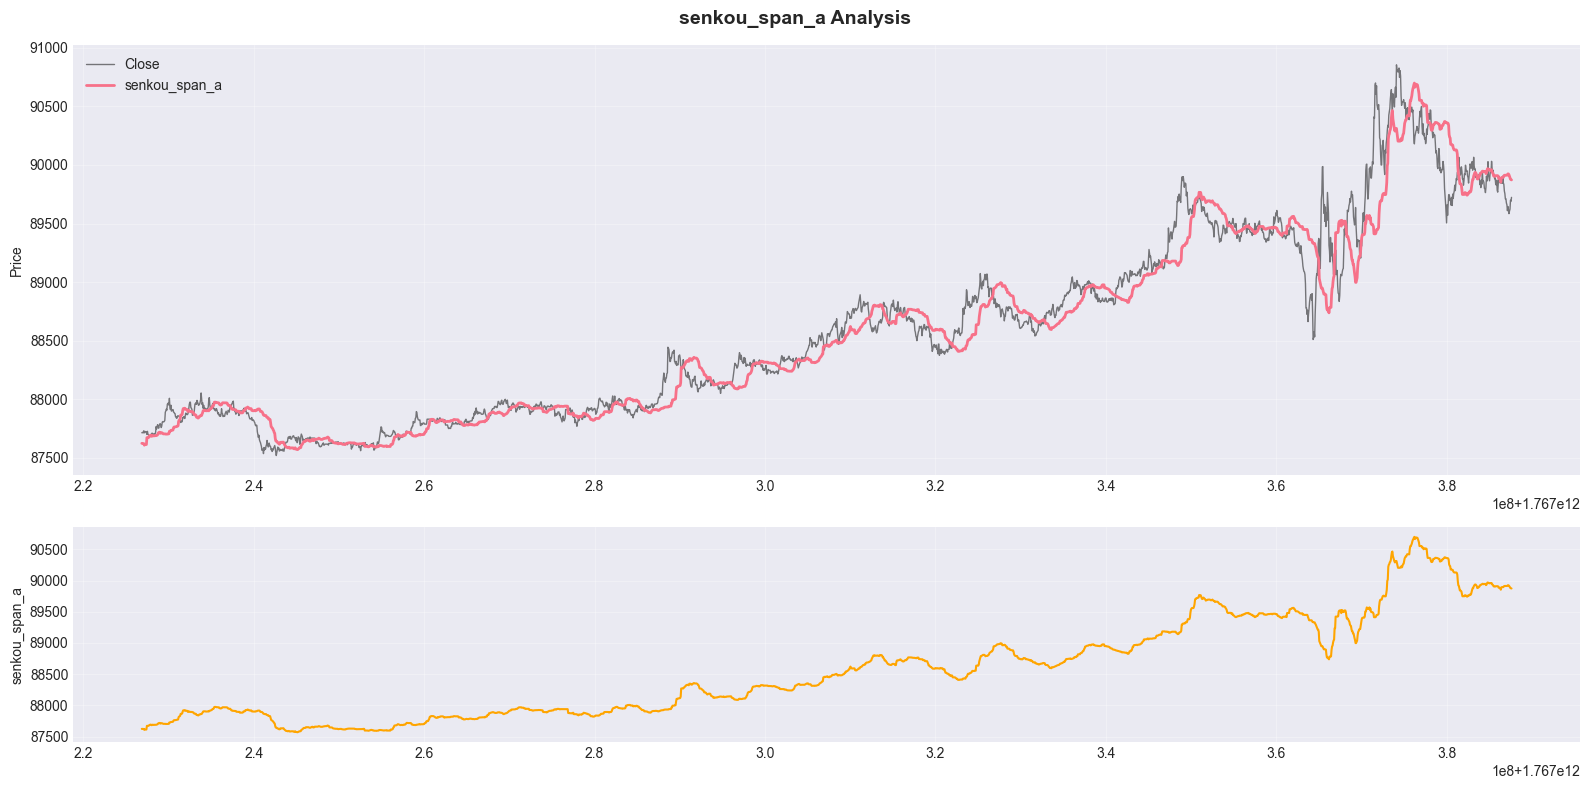

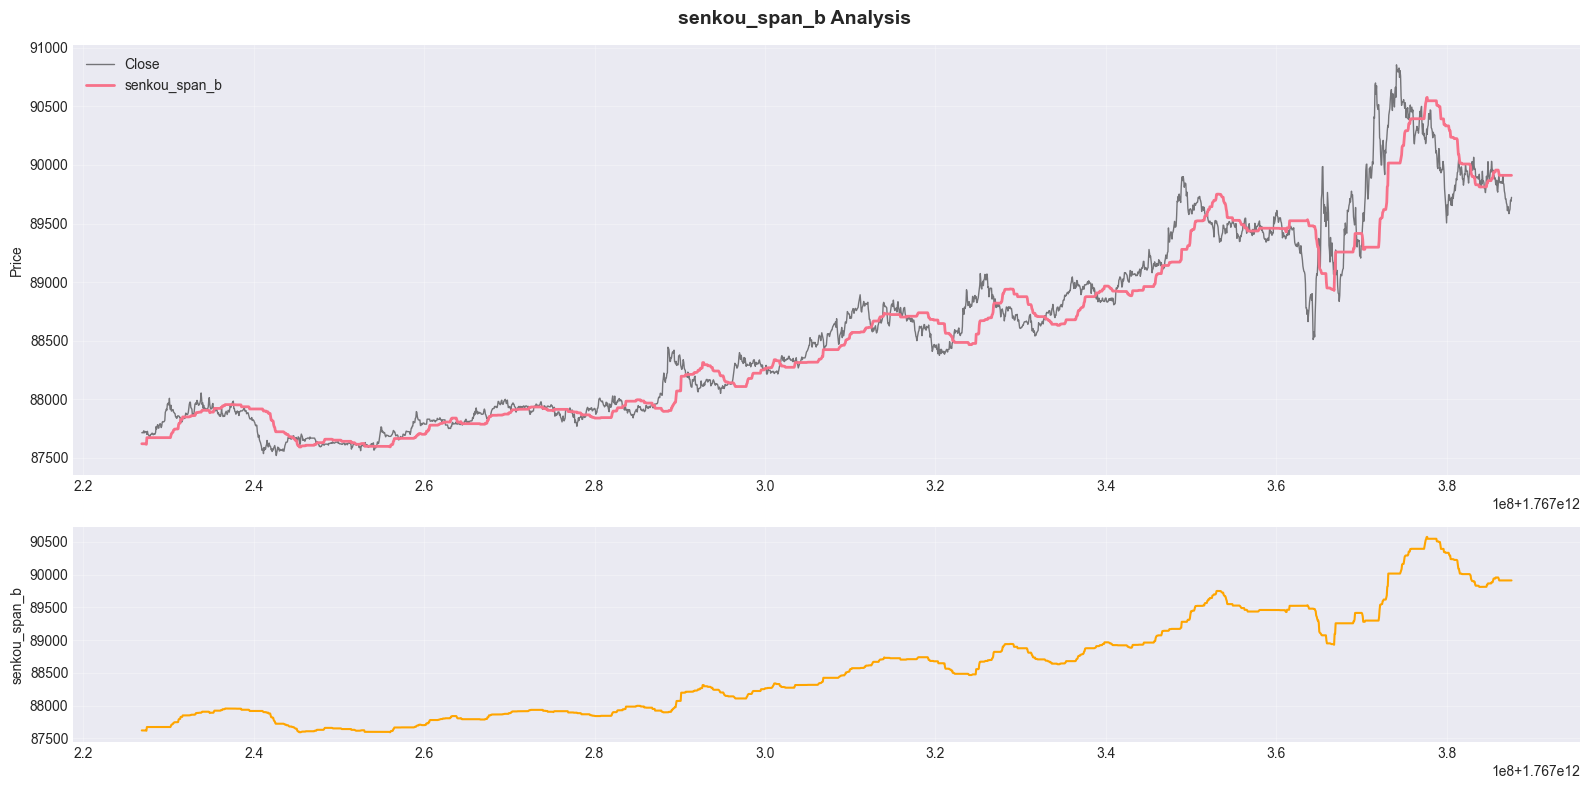

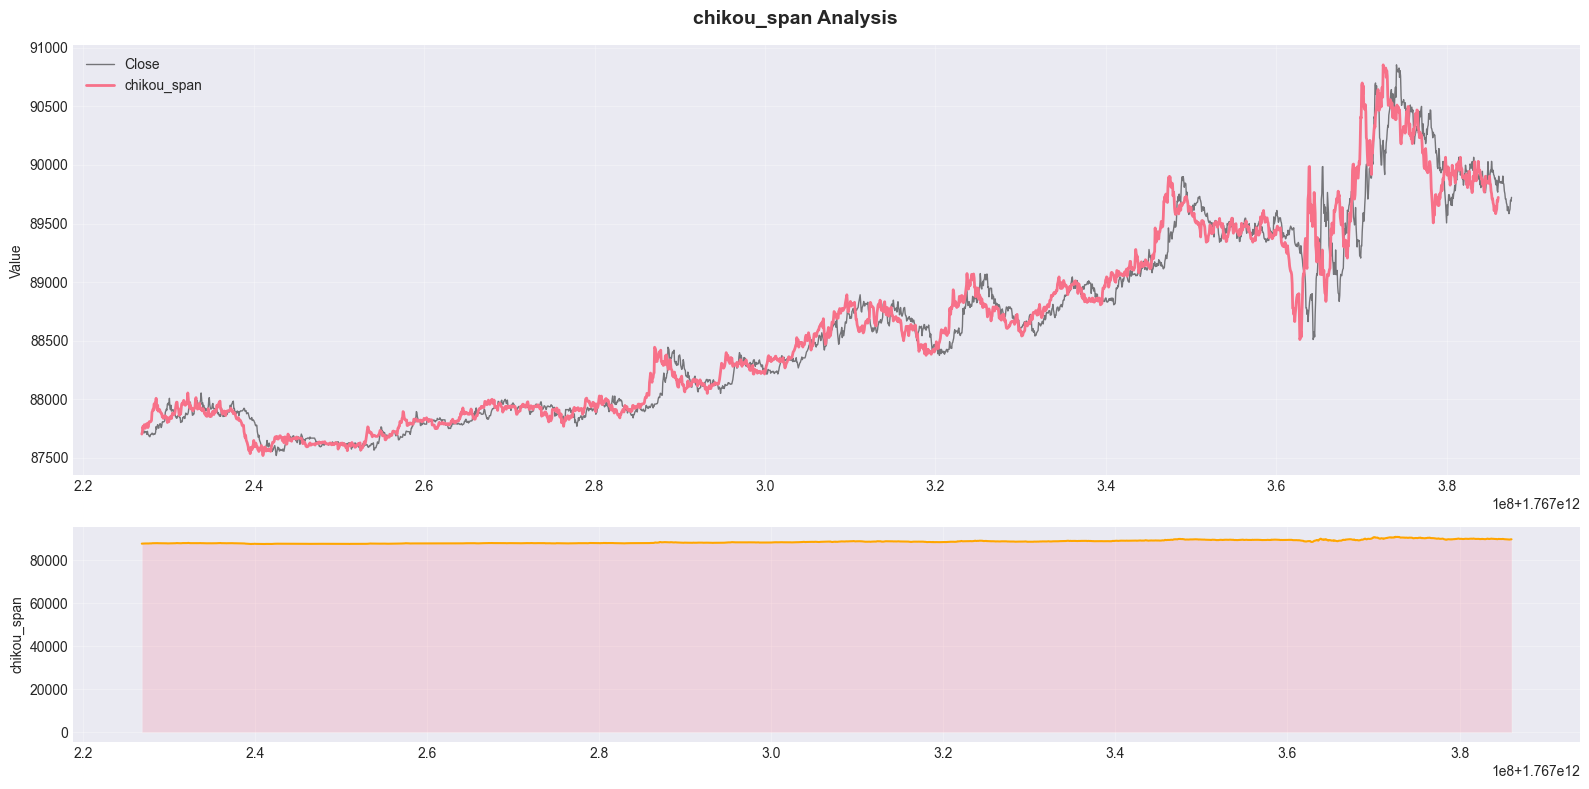

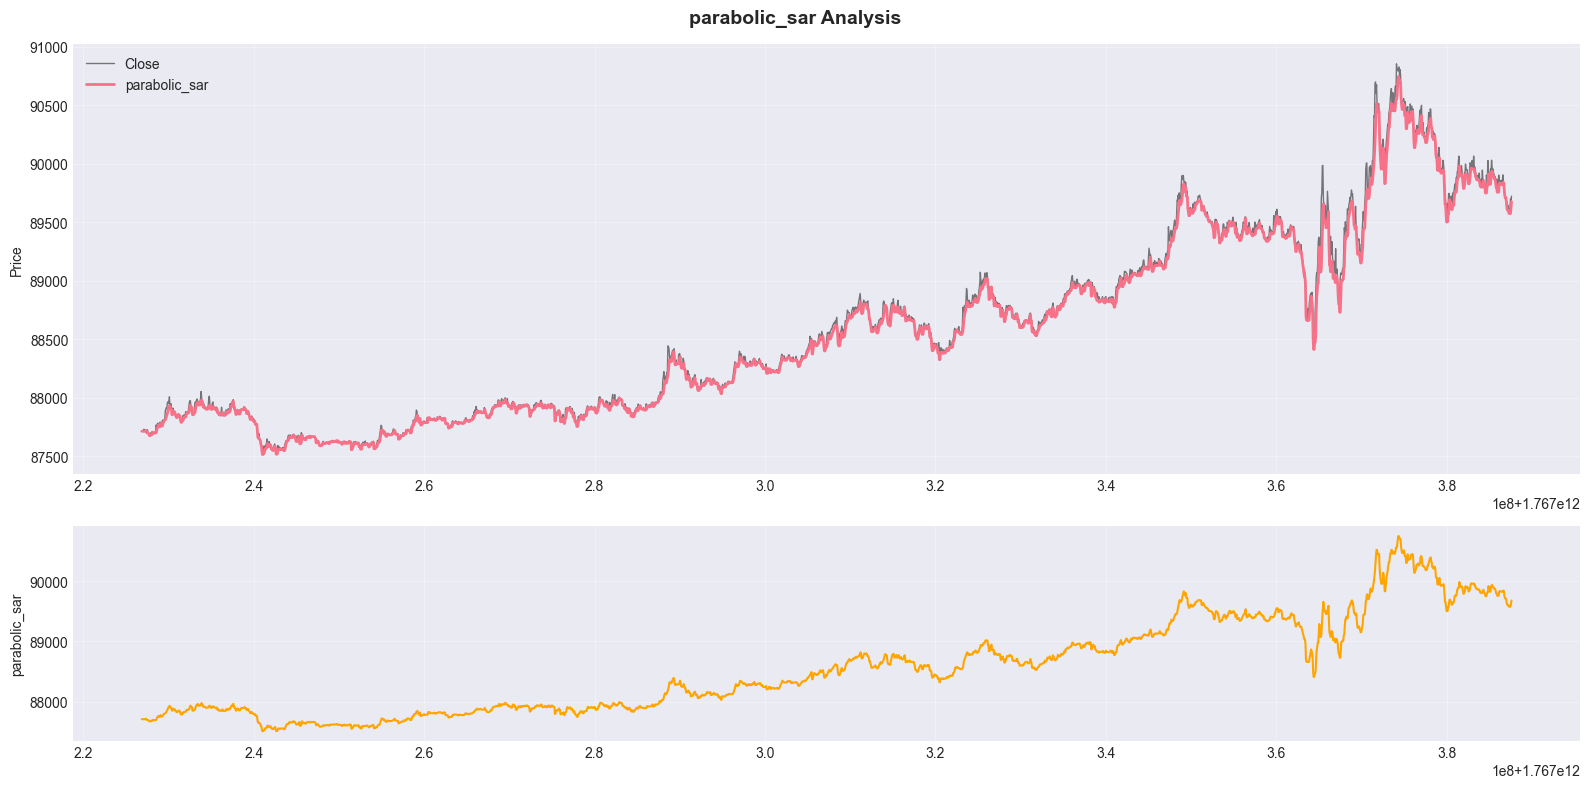

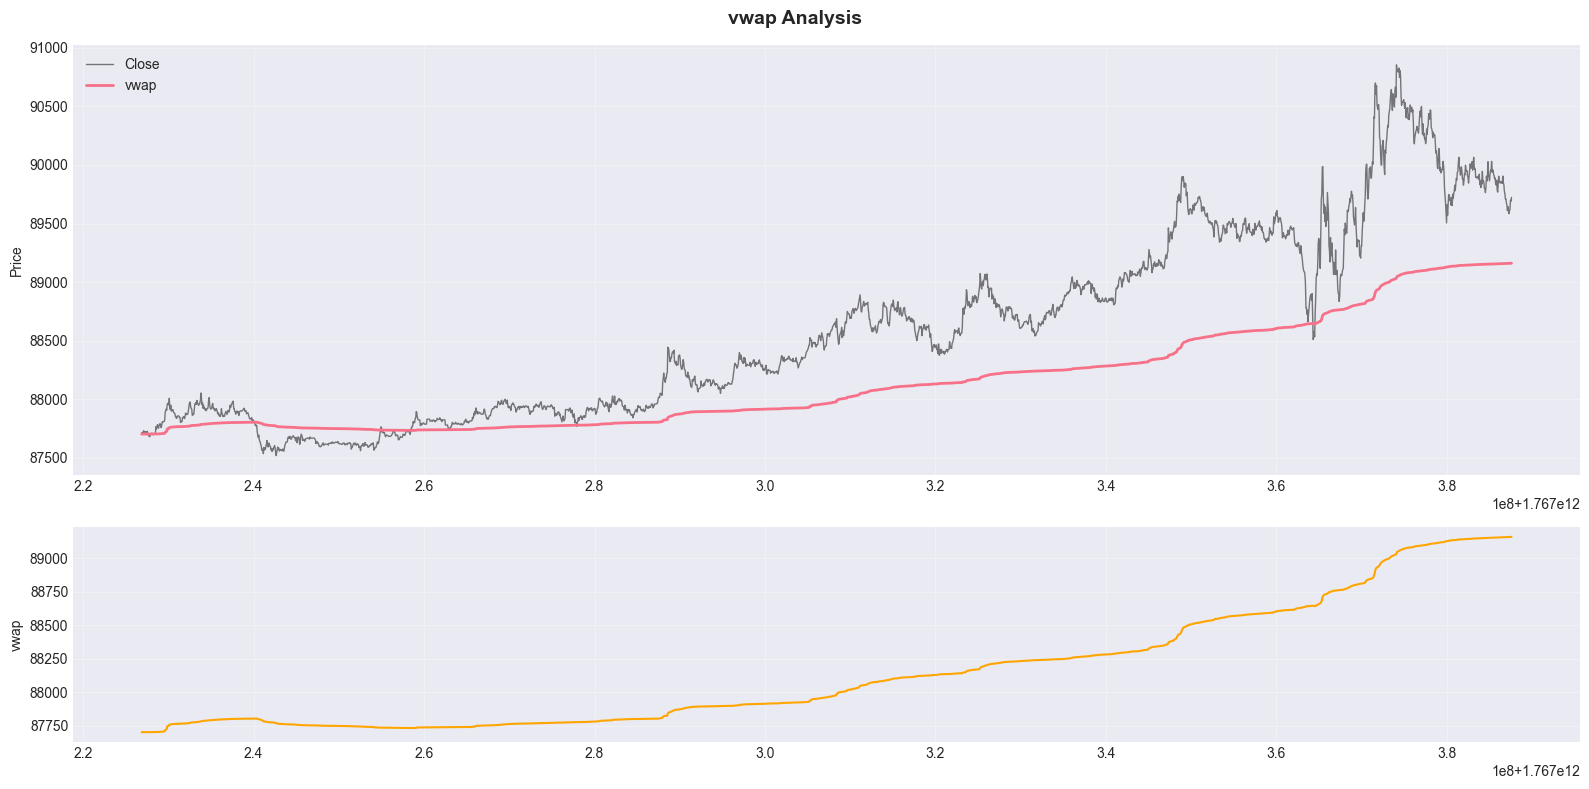

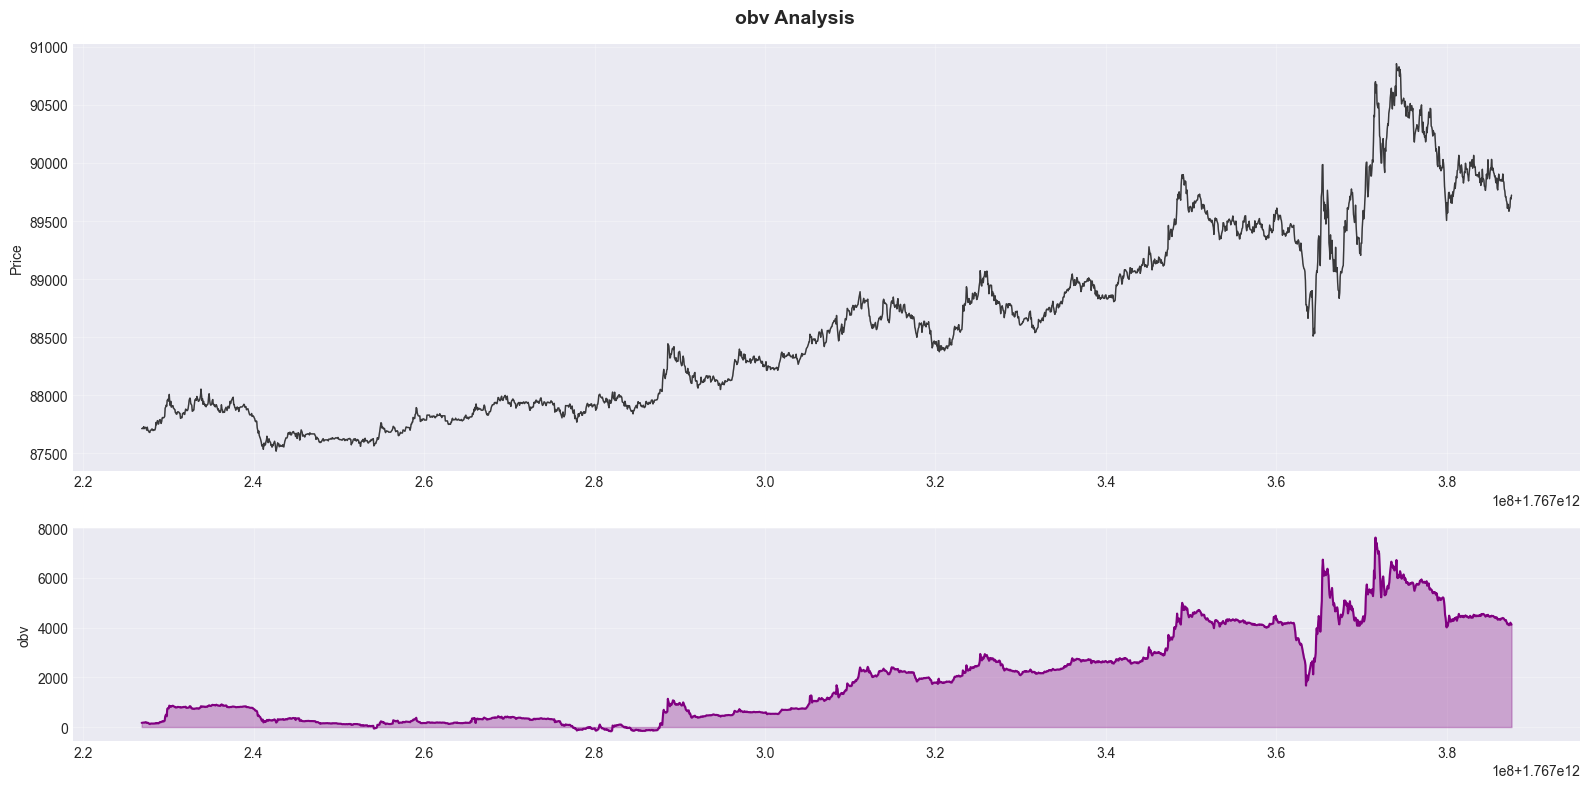

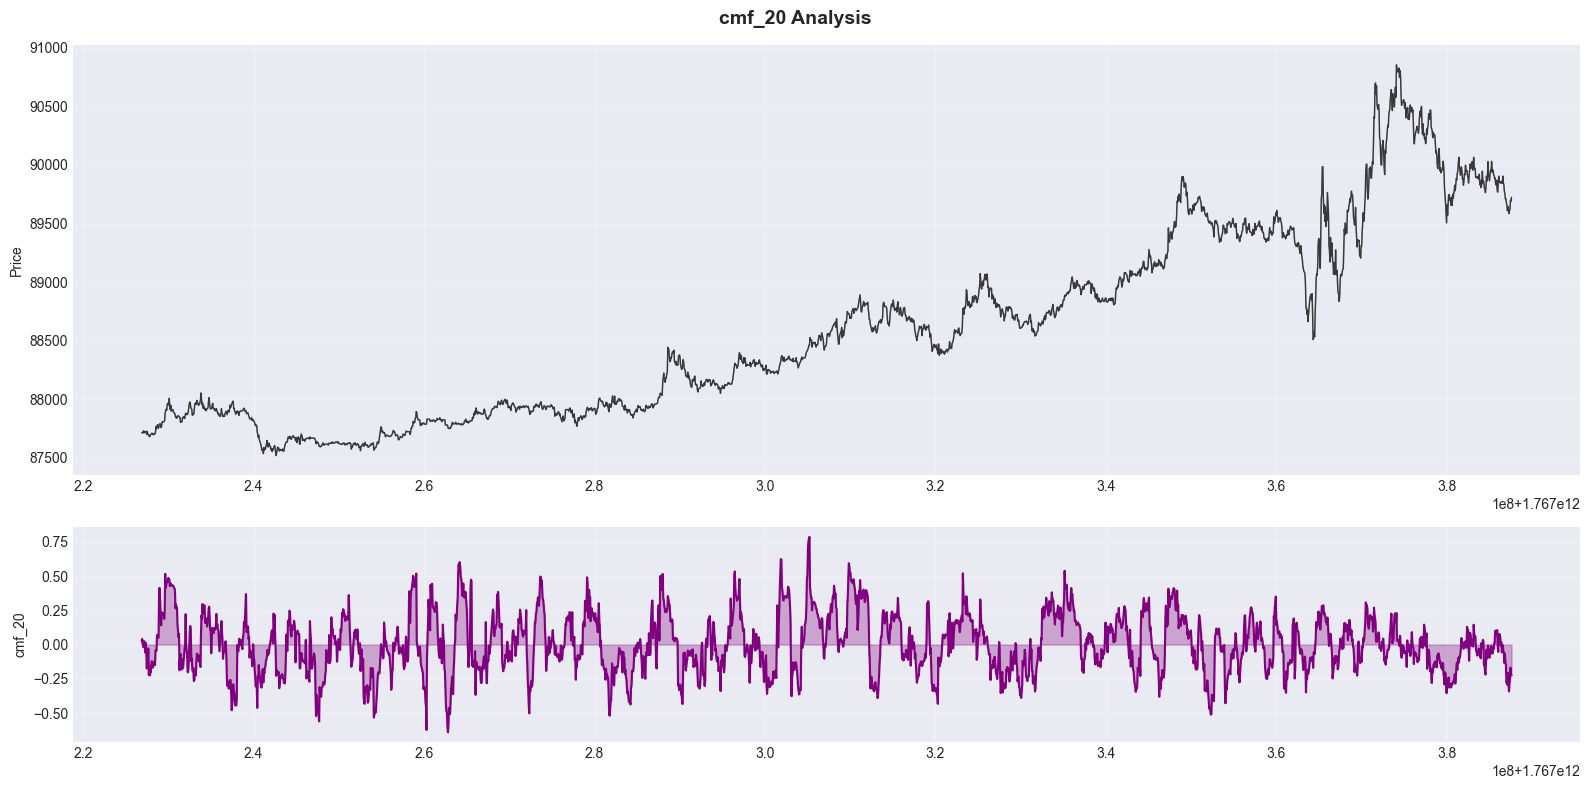

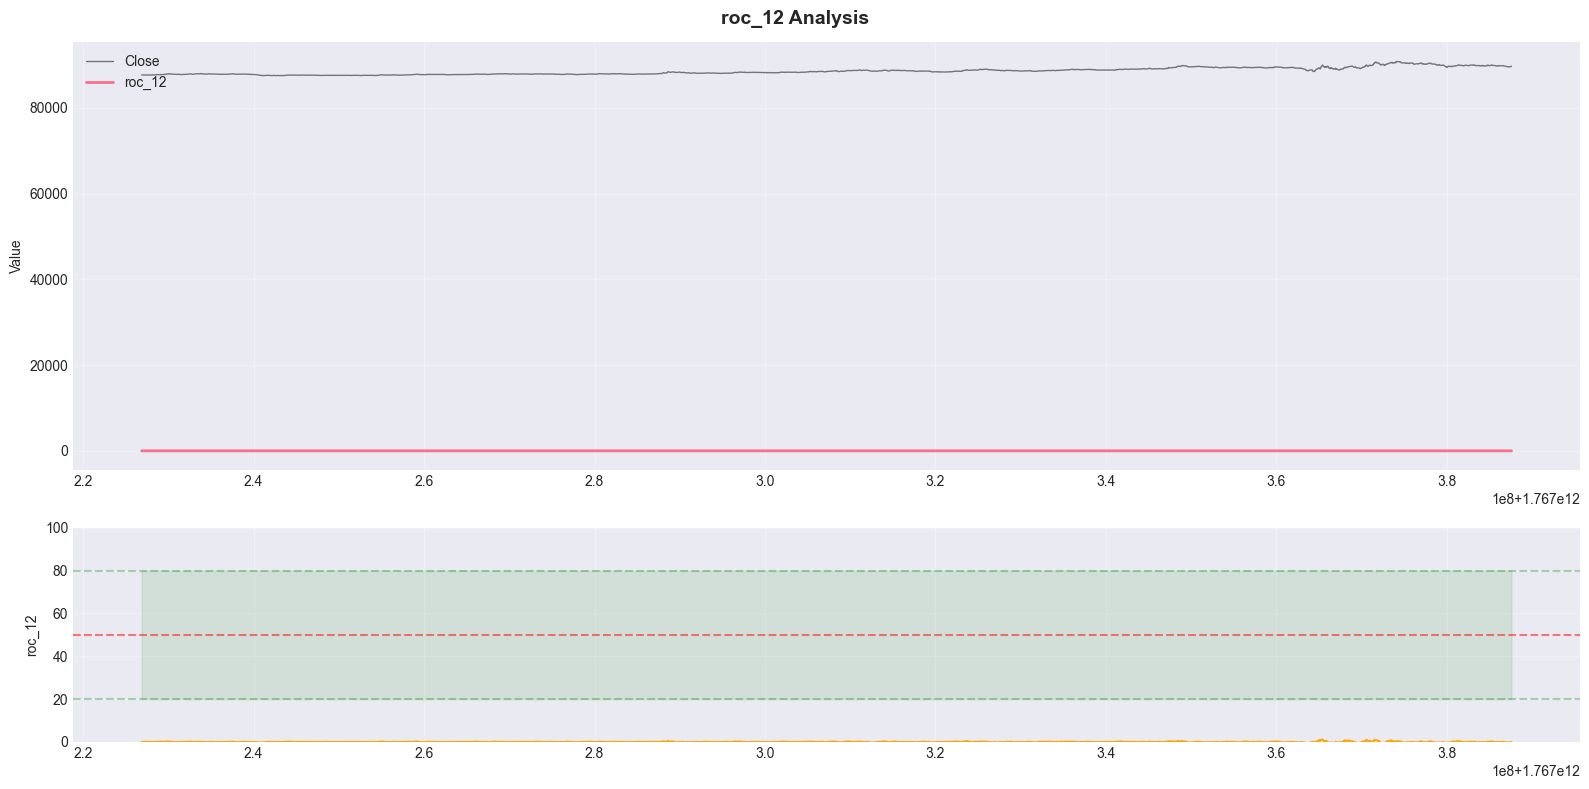

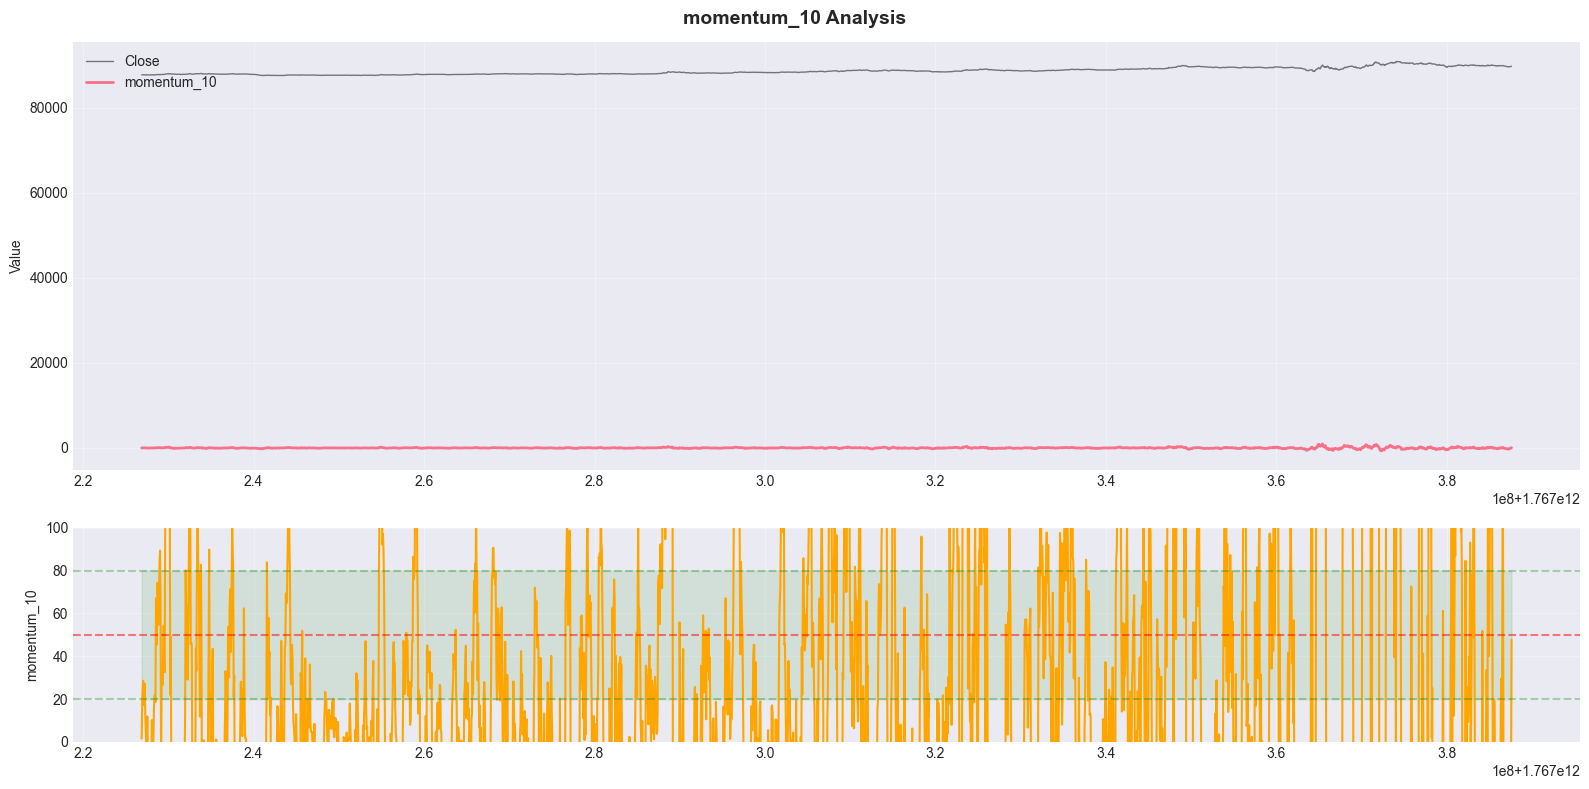

In [11]:

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

price_based = ['sma_20', 'sma_50', 'sma_200', 'ema_12', 'ema_26', 'wma_20', 'hma_20',
               'bb_middle', 'bb_upper', 'bb_lower', 'kc_middle', 'kc_upper', 'kc_lower',
               'dc_middle', 'dc_upper', 'dc_lower', 'vwap', 'parabolic_sar',
               'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b']

oscillators = ['rsi_14', 'stoch_k', 'stoch_d', 'williams_r', 'cci_20', 'mfi_14',
               'bb_percent_b', 'roc_12', 'momentum_10']

macd_related = ['macd', 'macd_signal', 'macd_histogram']
volume_related = ['obv', 'cmf_20']
other = ['bb_bandwidth', 'atr_14', 'plus_di', 'minus_di', 'adx', 'chikou_span']

for col in df_ind.columns:
    if col in ['timestamp', 'open', 'high', 'low', 'close', 'volume']:
        continue

    fig, axes = plt.subplots(2, 1, figsize=(16, 8),
                             gridspec_kw={'height_ratios': [2, 1]})

    axes[0].plot(df_ind.index, df_ind['close'], label='Close', color='black', alpha=0.5, linewidth=1)

    if col in price_based:
        axes[0].plot(df_ind.index, df_ind[col], label=col, linewidth=2)
        axes[0].set_ylabel('Price')
        axes[0].legend(loc='upper left')
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(df_ind.index, df_ind[col], color='orange', linewidth=1.5)
        axes[1].set_ylabel(col)
        axes[1].grid(True, alpha=0.3)

    elif col in oscillators:
        axes[0].plot(df_ind.index, df_ind[col], label=col, linewidth=2)
        axes[0].set_ylabel('Value')
        axes[0].legend(loc='upper left')
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(df_ind.index, df_ind[col], color='orange', linewidth=1.5)
        axes[1].axhline(y=50, color='red', linestyle='--', alpha=0.5)
        axes[1].axhline(y=20, color='green', linestyle='--', alpha=0.3)
        axes[1].axhline(y=80, color='green', linestyle='--', alpha=0.3)
        axes[1].fill_between(df_ind.index, 20, 80, alpha=0.1, color='green')
        axes[1].set_ylabel(col)
        axes[1].set_ylim(0, 100)
        axes[1].grid(True, alpha=0.3)

    elif col in macd_related:
        if col == 'macd_histogram':
            axes[0].bar(df_ind.index, df_ind[col], label=col, alpha=0.7, width=0.8)
            axes[1].bar(df_ind.index, df_ind[col], alpha=0.7, width=0.8)
        else:
            axes[0].plot(df_ind.index, df_ind[col], label=col, linewidth=2)
            axes[1].plot(df_ind.index, df_ind[col], linewidth=2)
        axes[0].set_ylabel('MACD')
        axes[0].legend(loc='upper left')
        axes[0].grid(True, alpha=0.3)
        axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
        axes[1].grid(True, alpha=0.3)

    elif col in volume_related:
        axes[0].plot(df_ind.index, df_ind['close'], label='Close', color='black', alpha=0.5, linewidth=1)
        axes[0].set_ylabel('Price')
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(df_ind.index, df_ind[col], color='purple', linewidth=1.5)
        axes[1].fill_between(df_ind.index, 0, df_ind[col], alpha=0.3, color='purple')
        axes[1].set_ylabel(col)
        axes[1].grid(True, alpha=0.3)

    elif col == 'adx':
        axes[0].plot(df_ind.index, df_ind['close'], label='Close', color='black', alpha=0.5, linewidth=1)
        axes[0].plot(df_ind.index, df_ind['plus_di'], label='+DI', linewidth=1.5)
        axes[0].plot(df_ind.index, df_ind['minus_di'], label='-DI', linewidth=1.5)
        axes[0].set_ylabel('DI')
        axes[0].legend(loc='upper left')
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(df_ind.index, df_ind[col], color='red', linewidth=2)
        axes[1].axhline(y=25, color='green', linestyle='--', alpha=0.5)
        axes[1].fill_between(df_ind.index, 0, df_ind[col], alpha=0.2, color='red')
        axes[1].set_ylabel('ADX')
        axes[1].set_ylim(0, 100)
        axes[1].grid(True, alpha=0.3)

    elif col in ['plus_di', 'minus_di']:
        continue

    else:
        axes[0].plot(df_ind.index, df_ind[col], label=col, linewidth=2)
        axes[0].set_ylabel('Value')
        axes[0].legend(loc='upper left')
        axes[0].grid(True, alpha=0.3)

        axes[1].plot(df_ind.index, df_ind[col], color='orange', linewidth=1.5)
        axes[1].fill_between(df_ind.index, 0, df_ind[col], alpha=0.2)
        axes[1].set_ylabel(col)
        axes[1].grid(True, alpha=0.3)

    plt.suptitle(f'{col} Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## Оценка предиктивной силы индикаторов

Сделаем корреляционный анализ каждого индикатора с будущей доходностью на следующую свечу. Это даст первое ощущение, какие индикаторы потенциально предсказывают движение цены.

In [5]:
#пусть предсказательная сила будет -5 свечей
df_ind['future_return'] = df_ind['close'].shift(-5) / df_ind['close'] - 1
df_ind['target'] = (df_ind['future_return'] > 0).astype(int)  # 1 = рост, 0 = падение

indicators = [
    col for col in df_ind.columns
    if col not in ['close', 'open', 'high', 'low', 'volume', 'future_return', 'target']
]
print(indicators)
df_ind.tail()


['sma_20', 'sma_50', 'sma_200', 'ema_12', 'ema_26', 'wma_20', 'hma_20', 'rsi_14', 'stoch_k', 'stoch_d', 'williams_r', 'cci_20', 'mfi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_middle', 'bb_upper', 'bb_lower', 'bb_bandwidth', 'bb_percent_b', 'kc_middle', 'kc_upper', 'kc_lower', 'dc_middle', 'dc_upper', 'dc_lower', 'atr_14', 'plus_di', 'minus_di', 'adx', 'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b', 'chikou_span', 'parabolic_sar', 'vwap', 'obv', 'cmf_20', 'roc_12', 'momentum_10']


open     high      low    close  volume     sma_20  \
timestamp                                                              
1767387360000  89584.5  89622.0  89580.0  89606.0  37.595  89752.045   
1767387420000  89606.0  89622.8  89575.1  89622.5  18.383  89740.370   
1767387480000  89622.5  89699.0  89622.5  89699.0  47.599  89733.030   
1767387540000  89699.0  89747.9  89681.3  89690.0  87.530  89724.745   
1767387600000  89690.0  89746.7  89676.3  89723.4  25.014  89717.995   

                  sma_50     sma_200        ema_12        ema_26  ...  \
timestamp                                                         ...   
1767387360000  89831.904  89998.6545  89674.802930  89745.393226  ...   
1767387420000  89828.352  89994.3230  89666.756325  89736.290024  ...   
1767387480000  89826.440  89990.8605  89671.716890  89733.527800  ...   
1767387540000  89824.958  89987.1540  89674.529677  89730.303519  ...   
1767387600000  89823.244  89983.8360  89682.048188  89729.792147  ...   

               senkou_span_b  chikou_span  parabolic_sar          vwap  \
timestamp                                                                
1767387360000       89911.55          NaN        89575.8  89160.111097   
1767387420000       89911.55          NaN        89575.1  89160.191754   
1767387480000       89911.55          NaN        89575.1  89160.431634   
1767387540000       89911.55          NaN        89622.5  89160.900414   
1767387600000       89911.55          NaN        89676.3  89161.036456   

                    obv    cmf_20    roc_12  momentum_10  future_return  \
timestamp                                                                 
1767387360000  4132.597 -0.282153 -0.268012       -171.6            NaN   
1767387420000  4150.980 -0.258502 -0.234990       -133.2            NaN   
1767387480000  4198.579 -0.168038 -0.087550        -10.7            NaN   
1767387540000  4111.049 -0.222547 -0.073199        -22.1            NaN   
1767387600000  4136.063 -0.224026  0.015271         47.8            NaN   

               target  
timestamp              
1767387360000       0  
1767387420000       0  
1767387480000       0  
1767387540000       0  
1767387600000       0  

[5 rows x 49 columns]

macd_signal     -0.126986
macd            -0.100367
dc_lower        -0.061506
tenkan_sen      -0.055010
bb_lower        -0.054836
dc_middle       -0.052919
parabolic_sar   -0.052820
kc_lower        -0.052776
chikou_span      0.051648
hma_20          -0.050565
dtype: float64


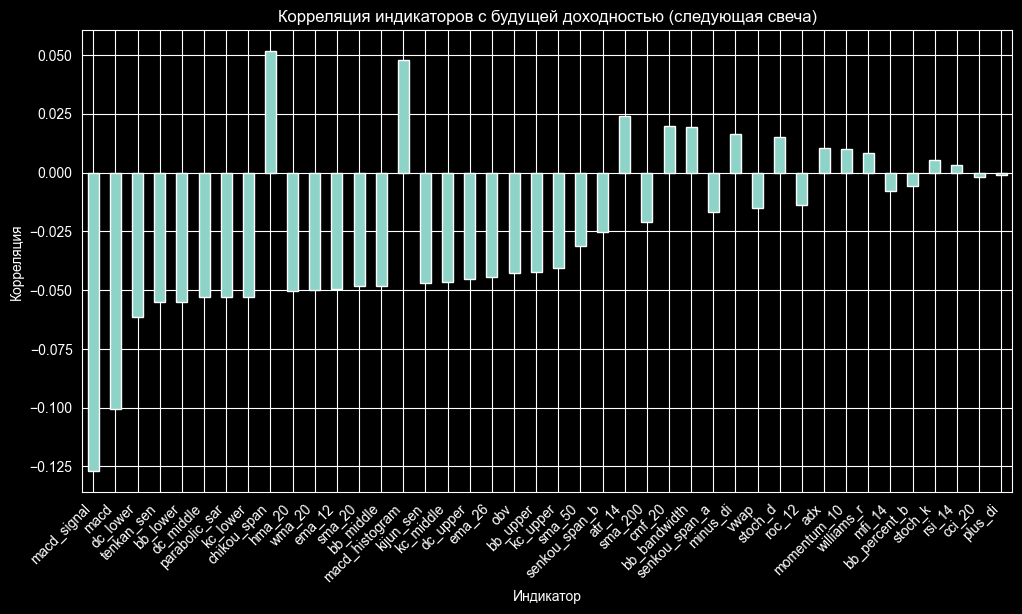

In [6]:
correlations = df_ind[indicators].corrwith(df_ind['future_return'])

correlations = correlations.reindex(correlations.abs().sort_values(ascending=False).index)

print(correlations.head(10))


plt.figure(figsize=(12,6))
correlations.plot(kind='bar')
plt.title("Корреляция индикаторов с будущей доходностью (следующая свеча)")
plt.ylabel("Корреляция")
plt.xlabel("Индикатор")
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

Вывод не утешительный - ни один индикатор линейно не предсказывает цену, что ясно. Посмотрим на взаимную информацию

Топ-10 индикаторов по взаимной информации:
kc_lower         0.018424
ema_12           0.017085
wma_20           0.016046
tenkan_sen       0.015243
sma_50           0.014251
dc_lower         0.014001
senkou_span_b    0.013879
ema_26           0.013127
kc_middle        0.013047
bb_lower         0.013045
dtype: float64


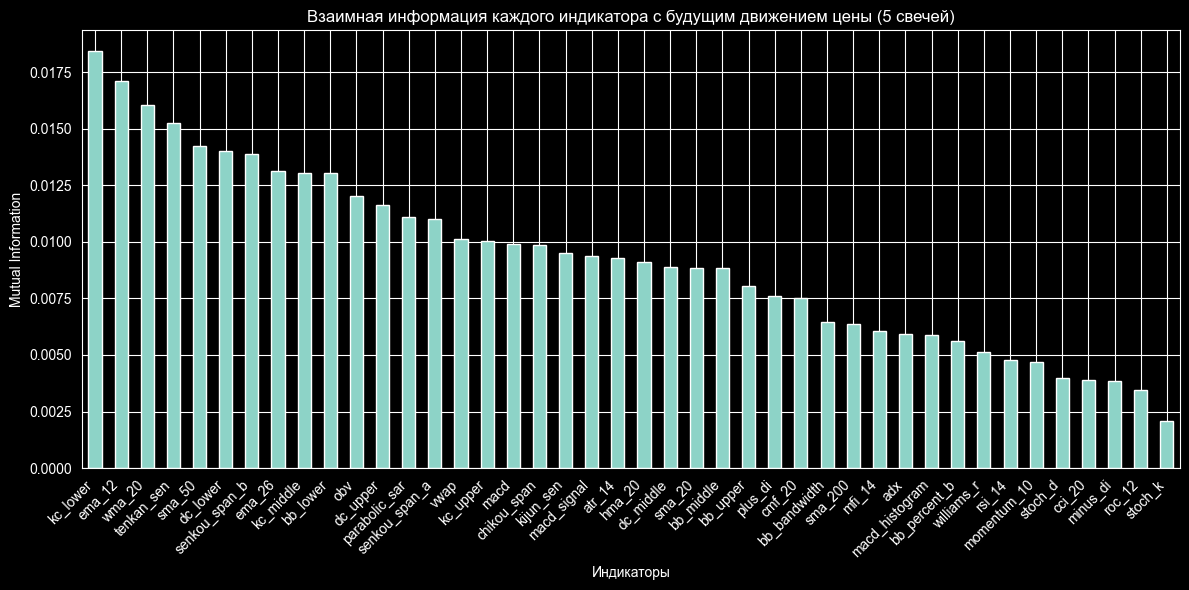

In [7]:

def mutual_information(x, y, bins=20):
    """
    Вычисляет взаимную информацию между числовой переменной x и бинарной y
    через гистограмму 2D.
    """
    # дискретизируем x в bins
    x_binned = pd.cut(x, bins=bins, labels=False)

    # создаём частотную таблицу
    c_xy = np.zeros((bins, 2))
    for xi, yi in zip(x_binned, y):
        c_xy[xi, yi] += 1

    # нормируем до вероятностей
    p_xy = c_xy / np.sum(c_xy)
    p_x = np.sum(p_xy, axis=1)
    p_y = np.sum(p_xy, axis=0)

    mi = 0.0
    for i in range(bins):
        for j in range(2):
            if p_xy[i,j] > 0:
                mi += p_xy[i,j] * np.log(p_xy[i,j] / (p_x[i]*p_y[j]))
    return mi

# Подготовка данных
df_mi = df_ind[indicators + ['target']].dropna()
mi_scores = {col: mutual_information(df_mi[col].values, df_mi['target'].values, bins=20)
             for col in indicators}

mi_series = pd.Series(mi_scores).sort_values(ascending=False)

# Топ-10 индикаторов
print("Топ-10 индикаторов по взаимной информации:")
print(mi_series.head(10))

plt.figure(figsize=(12,6))
mi_series.plot(kind='bar')
plt.title("Взаимная информация каждого индикатора с будущим движением цены (5 свечей)")
plt.ylabel("Mutual Information")
plt.xlabel("Индикаторы")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Вывод: ни один из индикаторов сам по себе сильно не предсказывает краткосрочное движение цены (5 свечей)

Последний шанс: попробуем построить дерево решений с индикаторами и без них. Посмотрим как будет отличаться его решение

In [16]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

def add_lags(df, columns, n_lags=3):
    df_lagged = df.copy()
    for col in columns:
        for lag in range(1, n_lags + 1):
            df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)
    return df_lagged

def prepare_features(df, feature_cols, n_lags=3):
    df_feat = add_lags(df[feature_cols], feature_cols, n_lags)
    df_feat = df_feat.iloc[n_lags:].interpolate().bfill().ffill()
    return df_feat

df = df_ind.copy()
df['target'] = df['close'].shift(-5) / df['close'] - 1

base_features = ['open', 'high', 'low', 'close', 'volume']
indicator_features = [col for col in df.columns if col not in ['open','high','low','close','volume','target','timestamp']]

X_base = prepare_features(df, base_features, n_lags=3)
X_full = prepare_features(df, base_features + indicator_features, n_lags=3)

y = df['target'].iloc[3:].fillna(0)

split_idx = int(len(X_base) * 0.8)
X_base_train, X_base_test = X_base.iloc[:split_idx], X_base.iloc[split_idx:]
X_full_train, X_full_test = X_full.iloc[:split_idx], X_full.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

rf_base = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42, n_jobs=-1)
rf_base.fit(X_base_train, y_train)
y_pred_base = rf_base.predict(X_base_test)

rf_full = RandomForestRegressor(n_estimators=200, max_depth=7, random_state=42, n_jobs=-1)
rf_full.fit(X_full_train, y_train)
y_pred_full = rf_full.predict(X_full_test)

print("="*60)
print("BASELINE MODEL (only OHLCV + lags)")
print("="*60)
print(f"RMSE: {mean_squared_error(y_test, y_pred_base):.6f}")
print(f"R²:   {r2_score(y_test, y_pred_base):.4f}")
print(f"Features: {len(X_base_train.columns)}")

print("\n" + "="*60)
print("FULL MODEL (with indicators + lags)")
print("="*60)
print(f"RMSE: {mean_squared_error(y_test, y_pred_full):.6f}")
print(f"R²:   {r2_score(y_test, y_pred_full):.4f}")
print(f"Features: {len(X_full_train.columns)}")

improvement_rmse = (mean_squared_error(y_test, y_pred_base) -
                    mean_squared_error(y_test, y_pred_full)) / \
                    mean_squared_error(y_test, y_pred_base) * 100

improvement_r2 = (r2_score(y_test, y_pred_full) - r2_score(y_test, y_pred_base)) / \
                  abs(r2_score(y_test, y_pred_base)) * 100

print("\n" + "="*60)
print("IMPROVEMENT")
print("="*60)
print(f"RMSE improvement: {improvement_rmse:+.2f}%")
print(f"R² improvement:   {improvement_r2:+.2f}%")

fi = pd.DataFrame({
    'Feature': X_full_train.columns,
    'Importance': rf_full.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n" + "="*60)
print("TOP 20 FEATURES")
print("="*60)
print(fi.head(20).to_string(index=False))

C:\Users\Chay\AppData\Local\Temp\ipykernel_27024\844134168.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_lagged[f"{col}_lag{lag}"] = df_lagged[col].shift(lag)


BASELINE MODEL (only OHLCV + lags)
RMSE: 0.000005
R²:   -0.2605
Features: 20

FULL MODEL (with indicators + lags)
RMSE: 0.000001
R²:   0.8281
Features: 192

IMPROVEMENT
RMSE improvement: +86.36%
R² improvement:   +417.94%

TOP 20 FEATURES
            Feature  Importance
      future_return    0.998125
      minus_di_lag2    0.000137
           minus_di    0.000074
        roc_12_lag3    0.000063
   macd_signal_lag2    0.000057
      bb_lower_lag1    0.000050
             mfi_14    0.000043
   chikou_span_lag1    0.000041
macd_histogram_lag2    0.000040
        rsi_14_lag3    0.000037
       stoch_k_lag1    0.000035
      bb_upper_lag2    0.000027
            sma_200    0.000025
              close    0.000025
                adx    0.000024
             hma_20    0.000023
                low    0.000022
             cmf_20    0.000021
 future_return_lag3    0.000021
      minus_di_lag3    0.000019

BOTTOM 10 FEATURES
        Feature   Importance
      kijun_sen 7.502797e-07
 dc_middle_

## Вывод

*Технические индикаторы линейно не предсказывают цену. Взаимная информация между ними и данными на 5 свечей вперед также очень маленькая, однако эксперемент с RandomForest показал, что наличие индикаторов очень влияет на предсказательную силу. Можем сделать вывод, что единые индикаторы мало влияют на цену, но их совокупность обладает предсказательной силой*